In [1]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import multiprocessing as mp
import os
import torchvision.transforms as transforms
from PIL import Image
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tqdm import tqdm_notebook
from tqdm import tnrange

# Using default dataset 

In [2]:
number_of_imgs_to_load_foreach_class = 5

In [3]:
def extract_images(folder_path, split_separator = '_'):
    image_dict = {}

    image_files = glob.glob(os.path.join(folder_path, '*.png'))

    for file_path in image_files:
        file_name = os.path.basename(file_path)
        image_name = file_name.split(split_separator)[0]

        if image_name not in image_dict:
            image_dict[image_name] = []

        image_dict[image_name].append(file_path)

    images_list = []
    classes_list = []
    selected_dict = {}
    for image_name, image_paths in image_dict.items():
        selected_dict[image_name] = image_paths[:number_of_imgs_to_load_foreach_class]
        images_list.extend(image_paths[:number_of_imgs_to_load_foreach_class])
        classes_list.extend([image_name] * len(image_paths[:number_of_imgs_to_load_foreach_class]))

    return images_list, classes_list, selected_dict

In [4]:
images, images_classes, images_dict = extract_images('../data/img/')

In [5]:
images = [cv2.imread(img) for img in images]
len(images)

27

In [6]:
len(images_classes), len(set(images_classes))

(27, 6)

In [7]:
classes = set(images_classes)
len(classes), classes

(6, {'break', 'bubble', 'dirt', 'mark', 'point', 'scratch'})

In [8]:
def plot_comparison(title1, title2, img1, img2):
    fig = plt.figure(figsize=(6, 4))
    rows = 1
    columns = 2
    fig.add_subplot(rows, columns, 1)

    plt.imshow(img1)
    plt.axis('off')
    plt.title(title1)

    fig.add_subplot(rows, columns, 2)

    plt.imshow(img2)
    plt.axis('off')
    plt.title(title2)

In [9]:
# plot_comparison("Image from images", "Mask image from labels", images[0], masks[0])

In [10]:
def augment_image(image):
    augmented_images = []

    augmented_images.append(image)

    flipped_x = cv2.flip(image, 0)
    augmented_images.append(flipped_x)

    flipped_y = cv2.flip(image, 1)
    augmented_images.append(flipped_y)

    rotated_180 = cv2.rotate(image, cv2.ROTATE_180)
    augmented_images.append(rotated_180)

    return augmented_images

In [11]:
def pil_to_cv2(image_pil):
    image_np = np.array(image_pil)
    image_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

    return image_bgr

def resize_image(image, label, output_size):
    default_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.CenterCrop(output_size),
        transforms.Resize((output_size, output_size))
    ])

    break_mark_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((output_size, output_size))
    ])

    resized_image = break_mark_transform(image) if label == 'break' or label == 'mark' else default_transform(image)
    resized_image = pil_to_cv2(resized_image)

    return resized_image

(60, 60, 3)


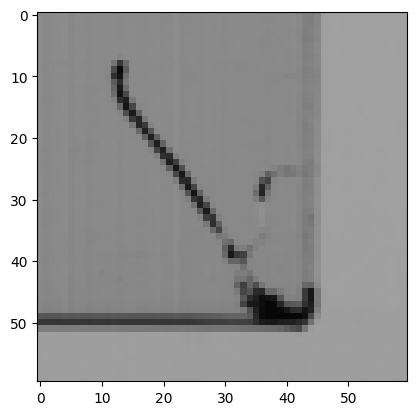

In [12]:
ex = resize_image(cv2.imread(images_dict['break'][0]), 'break', 60)
print(ex.shape)
plt.imshow(ex)

In [13]:
def preprocess_images(dict, index, size):
    for key in dict.keys():
        dict[key] = [img[:index] + '/' + img[index + 1:] for img in dict[key]]
        dict[key] = [aug for img in dict[key] for aug in augment_image(cv2.imread(img))]
        dict[key] = [resize_image(img, key, size) for img in dict[key]]
    
    return dict

In [14]:
def extend_target_classes(images_classes, n):
    target_classes = []
    for cls in images_classes:
        target_classes.extend([cls] * n)
    
    return target_classes

In [15]:
images_dict = preprocess_images(images_dict, 11, 60)
target_classes = extend_target_classes(images_classes, 4)

# for key in images_dict.keys():
#     images_dict[key] = [img[:11] + '/' + img[12:] for img in images_dict[key]]
#     images_dict[key] = [aug for img in images_dict[key] for aug in augment_image(cv2.imread(img))]
#     images_dict[key] = [resize_image(img, key, 60) for img in images_dict[key]]

# for key in masks_dict.keys():
#     masks_dict[key] = [img[:13] + '/' + img[14:] for img in masks_dict[key]]
#     masks_dict[key] = [aug for img in masks_dict[key] for aug in augment_image(cv2.imread(img))]
#     masks_dict[key] = [resize_image(img, key, 60) for img in masks_dict[key]]

# target_classes = []
# for cls in images_classes:
#     target_classes.extend([cls] * 4)

In [16]:
def extract_sample(n_way, n_support, n_query, datax, datay):
    sample = []
    K = np.random.choice(np.unique(datay), n_way, replace=False)
    print('K:',K)

    for cls in K:
        datax_cls = np.random.permutation(datax[cls])[:(n_support + n_query)]
        sample.append(datax_cls)

    sample = np.array(sample)
    sample = torch.from_numpy(sample)

    sample = sample.permute(0, 1, 4, 2, 3)

    return({
        'images': sample,
        'n_way': n_way,
        'n_support': n_support,
        'n_query': n_query,
        'classes': list(K)
    })

In [17]:
sample_example = extract_sample(6, 4, 4, images_dict, images_classes)
sample_example['images'].shape, sample_example

K: ['dirt' 'break' 'bubble' 'scratch' 'mark' 'point']


(torch.Size([6, 8, 3, 60, 60]),
 {'images': tensor([[[[[141, 140, 143,  ..., 142, 140, 139],
             [145, 141, 141,  ..., 136, 139, 137],
             [145, 142, 145,  ..., 132, 133, 128],
             ...,
             [141, 138, 130,  ..., 143, 140, 142],
             [143, 142, 137,  ..., 141, 142, 140],
             [140, 143, 141,  ..., 145, 142, 142]],
  
            [[141, 140, 143,  ..., 142, 140, 139],
             [145, 141, 141,  ..., 136, 139, 137],
             [145, 142, 145,  ..., 132, 133, 128],
             ...,
             [141, 138, 130,  ..., 143, 140, 142],
             [143, 142, 137,  ..., 141, 142, 140],
             [140, 143, 141,  ..., 145, 142, 142]],
  
            [[141, 140, 143,  ..., 142, 140, 139],
             [145, 141, 141,  ..., 136, 139, 137],
             [145, 142, 145,  ..., 132, 133, 128],
             ...,
             [141, 138, 130,  ..., 143, 140, 142],
             [143, 142, 137,  ..., 141, 142, 140],
             [140, 143, 141, 

In [18]:
def display_sample(sample):
    sample_4D = sample.view(sample.shape[0]*sample.shape[1],*sample.shape[2:])
    out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])
    plt.figure(figsize = (16,7))
    plt.imshow(out.permute(1, 2, 0))

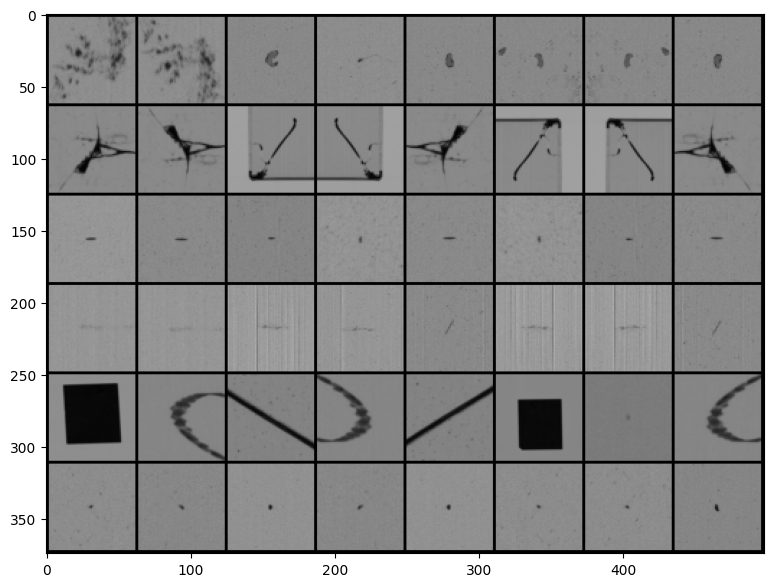

In [19]:
display_sample(sample_example['images'])

In [20]:
def euclidean_dist(x, y):
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    assert d == y.size(1)

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)

    return torch.pow(x - y, 2).sum(2)

In [21]:
class ProtoNet(nn.Module):
    def __init__(self, encoder):
        super(ProtoNet, self).__init__()
        self.encoder = encoder#.cuda()

    def set_forward_loss(self, sample, accuracy_dict):
        """
        Computes loss, accuracy and output for classification task
        Args:
            sample (torch.Tensor): shape (n_way, n_support+n_query, (dim)) 
        Returns:
            torch.Tensor: shape(2), loss, accuracy and y_hat
        """
        sample_images = sample['images']#.cuda()
        n_way = sample['n_way']
        n_support = sample['n_support']
        n_query = sample['n_query']
        sample_labels = sample['classes']

        x_support = sample_images[:, :n_support]
        x_query = sample_images[:, n_support:]

        #target indices are 0 ... n_way-1
        target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long()
        target_inds = Variable(target_inds, requires_grad=False)
        target_inds = target_inds#.cuda()

        #encode images of the support and the query set
        x = torch.cat([x_support.contiguous().view(n_way * n_support, *x_support.size()[2:]),
                        x_query.contiguous().view(n_way * n_query, *x_query.size()[2:])], 0)
        
        z = self.encoder.forward(x.float())
        z_dim = z.size(-1) 
        z_proto = z[:n_way*n_support].view(n_way, n_support, z_dim).mean(1)
        z_query = z[n_way*n_support:]

        #compute distances
        dists = euclidean_dist(z_query, z_proto)

        #compute probabilities
        log_p_y = F.log_softmax(-dists, dim=1).view(n_way, n_query, -1)

        loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()
        _, y_hat = log_p_y.max(2)
        acc_val = torch.eq(y_hat.squeeze(), target_inds.squeeze()).float().mean()

        accuracy_tensor = []
        for row_target, row_predicted in zip(target_inds.squeeze(), y_hat.squeeze()):
            accuracy = (row_target == row_predicted).float().mean()
            accuracy_tensor.append([accuracy])
        accuracy_tensor = torch.tensor(accuracy_tensor)

        for accuracy, cls in zip(accuracy_tensor, sample_labels):
            if cls not in accuracy_dict:
                accuracy_dict[cls] = []
            accuracy_dict[cls].append(accuracy.item())

        return loss_val, {
            'loss': loss_val.item(),
            'acc': acc_val.item(),
            'y_hat': y_hat.squeeze(),
            'y_true': target_inds.squeeze()
        }, accuracy_dict

In [22]:
class Flatten(nn.Module):
    def __init__(self):
      super(Flatten, self).__init__()

    def forward(self, x):
      return x.view(x.size(0), -1)

def load_protonet_conv(**kwargs):
    """
    Loads the prototypical network model
    Arg:
        x_dim (tuple): dimension of input image
        hid_dim (int): dimension of hidden layers in conv blocks
        z_dim (int): dimension of embedded image
    Returns:
        Model (Class ProtoNet)
    """
    x_dim = kwargs['x_dim']
    hid_dim = kwargs['hid_dim']
    z_dim = kwargs['z_dim']

    def conv_block(in_channels, out_channels):
      return nn.Sequential(
          nn.Conv2d(in_channels, out_channels, 3, padding=1),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(),
          nn.MaxPool2d(2)
          )
    
    encoder = nn.Sequential(
      conv_block(x_dim[0], hid_dim),
      conv_block(hid_dim, hid_dim),
      conv_block(hid_dim, hid_dim),
      conv_block(hid_dim, z_dim),
      Flatten()
    )
      
    return ProtoNet(encoder)

In [23]:
def  split_train_test(data, percentage = 3/4):
    train_x = {}
    test_x = {}
    for key in data.keys():
        dim = len(data[key])
        train_x[key] = data[key][:int(len(data[key])*percentage)]
        test_x[key] = data[key][-int(dim - int(dim*percentage)):]

    train_y = []
    test_y = []
    for key in data.keys():
        dim = len(data[key])
        train_y.extend([key] * int(dim*percentage))
        test_y.extend([key] * int(dim - int(dim*percentage)))

    for k in images_dict.keys():
        print(len(images_dict[k]))
    print('-----')
    for k in train_x.keys():
        print(len(train_x[k]))
    print('-----')
    for k in test_x.keys():
        print(len(test_x[k]))
    
    return train_x, train_y, test_x, test_y

In [24]:
train_x, train_y, test_x, test_y = split_train_test(images_dict, 1/2)

8
20
20
20
20
20
-----
4
10
10
10
10
10
-----
4
10
10
10
10
10


# Train

In [25]:
def train(model, optimizer, train_x, train_y, n_way, n_support, n_query, epochs, episodes):
    scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
    epoch = 0 #epochs done so far

    accuracy_dict = {}
    final_accuracy = 0

    while epoch < epochs:
        running_loss = 0.0
        running_acc = 0.0

        for episode in tnrange(episodes, desc="Epoch {:d} train".format(epoch+1)):
            sample = extract_sample(n_way, n_support, n_query, train_x, train_y)
            optimizer.zero_grad()
            loss, output, accuracy_dict = model.set_forward_loss(sample, accuracy_dict)
            running_loss += output['loss']
            running_acc += output['acc']
            loss.backward()
            optimizer.step()
            epoch_loss = running_loss / episodes
            epoch_acc = running_acc / episodes
            print('Epoch {:d} -- Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,epoch_loss, epoch_acc))
            final_accuracy = epoch_acc
            epoch += 1
            scheduler.step()

    return accuracy_dict, final_accuracy

In [26]:
def print_dictionary(dictionary):
    for key, values in dictionary.items():
        average = round(sum(values) / len(values), 3)
        print(f"{key}: Average recall: {average}")

In [27]:
%%time

model = load_protonet_conv(
    x_dim=(3,60,60),
    hid_dim=64,
    z_dim=64,
)

optimizer = optim.Adam(model.parameters(), lr = 0.001)

n_way = 3
n_support = 2
n_query = 1

epochs = 10
episodes = 50

accuracy_dict, _ = train(model, optimizer, train_x, train_y, n_way, n_support, n_query, epochs, episodes)
print('----------------------------------------------')
print_dictionary(accuracy_dict)

C:\Users\matte\AppData\Local\Temp\ipykernel_4876\1451704302.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes, desc="Epoch {:d} train".format(epoch+1)):


Epoch 1 train:   0%|          | 0/50 [00:00<?, ?it/s]

K: ['point' 'dirt' 'break']
Epoch 1 -- Loss: 0.0000 Acc: 0.0200
K: ['scratch' 'mark' 'dirt']
Epoch 2 -- Loss: 9.4574 Acc: 0.0333
K: ['scratch' 'break' 'bubble']
Epoch 3 -- Loss: 9.5112 Acc: 0.0467
K: ['break' 'dirt' 'mark']
Epoch 4 -- Loss: 9.7306 Acc: 0.0600
K: ['mark' 'bubble' 'scratch']
Epoch 5 -- Loss: 9.9408 Acc: 0.0733
K: ['scratch' 'dirt' 'bubble']
Epoch 6 -- Loss: 10.3273 Acc: 0.0867
K: ['mark' 'bubble' 'dirt']
Epoch 7 -- Loss: 12.3795 Acc: 0.0933
K: ['dirt' 'bubble' 'mark']
Epoch 8 -- Loss: 12.3795 Acc: 0.1133
K: ['mark' 'break' 'bubble']
Epoch 9 -- Loss: 12.3795 Acc: 0.1333
K: ['mark' 'dirt' 'bubble']
Epoch 10 -- Loss: 12.3795 Acc: 0.1533
K: ['bubble' 'point' 'scratch']
Epoch 11 -- Loss: 12.3795 Acc: 0.1733
K: ['scratch' 'point' 'mark']
Epoch 12 -- Loss: 12.5929 Acc: 0.1867
K: ['break' 'dirt' 'scratch']
Epoch 13 -- Loss: 12.5929 Acc: 0.2067
K: ['dirt' 'bubble' 'scratch']
Epoch 14 -- Loss: 13.1207 Acc: 0.2200
K: ['mark' 'break' 'dirt']
Epoch 15 -- Loss: 13.1480 Acc: 0.2333
K: 

# Test

In [28]:
def test(model, test_x, test_y, n_way, n_support, n_query, episodes):
    running_loss = 0.0
    running_acc = 0.0

    accuracy_dict = {}

    for episode in tnrange(episodes):
        sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
        loss, output, accuracy_dict = model.set_forward_loss(sample, accuracy_dict)
        running_loss += output['loss']
        running_acc += output['acc']
    avg_loss = running_loss / episodes
    avg_acc = running_acc / episodes
    print('Test results -- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))

    return accuracy_dict, avg_acc

In [29]:
len(train_x), len(train_y), len(test_x), len(test_y)

(6, 54, 6, 54)

In [30]:
n_way = 6
n_support = 2
n_query = 2

episodes = 50

accuracy_dict, _ = test(model, test_x, test_y, n_way, n_support, n_query, episodes)
print('----------------------------------------------')
print_dictionary(accuracy_dict)

C:\Users\matte\AppData\Local\Temp\ipykernel_4876\2763146824.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes):


  0%|          | 0/50 [00:00<?, ?it/s]

K: ['point' 'break' 'bubble' 'dirt' 'scratch' 'mark']
K: ['break' 'bubble' 'scratch' 'dirt' 'point' 'mark']
K: ['break' 'mark' 'scratch' 'dirt' 'bubble' 'point']
K: ['scratch' 'bubble' 'mark' 'point' 'dirt' 'break']
K: ['break' 'mark' 'scratch' 'bubble' 'point' 'dirt']
K: ['mark' 'point' 'scratch' 'bubble' 'break' 'dirt']
K: ['dirt' 'scratch' 'mark' 'bubble' 'point' 'break']
K: ['bubble' 'point' 'break' 'mark' 'scratch' 'dirt']
K: ['point' 'bubble' 'mark' 'dirt' 'scratch' 'break']
K: ['mark' 'point' 'dirt' 'bubble' 'break' 'scratch']
K: ['point' 'dirt' 'scratch' 'break' 'mark' 'bubble']
K: ['bubble' 'scratch' 'break' 'mark' 'dirt' 'point']
K: ['dirt' 'bubble' 'scratch' 'break' 'point' 'mark']
K: ['mark' 'scratch' 'point' 'bubble' 'break' 'dirt']
K: ['break' 'point' 'scratch' 'bubble' 'dirt' 'mark']
K: ['dirt' 'break' 'bubble' 'scratch' 'mark' 'point']
K: ['bubble' 'mark' 'dirt' 'break' 'point' 'scratch']
K: ['mark' 'bubble' 'dirt' 'scratch' 'break' 'point']
K: ['mark' 'scratch' 'bubble

# test on specific sample

In [31]:
accuracy_dict = {}

K: ['mark' 'break' 'point']
mark: Average recall: 1.0
break: Average recall: 1.0
point: Average recall: 1.0


{'loss': 0.15703722834587097,
 'acc': 1.0,
 'y_hat': tensor([0, 1, 2]),
 'y_true': tensor([0, 1, 2])}

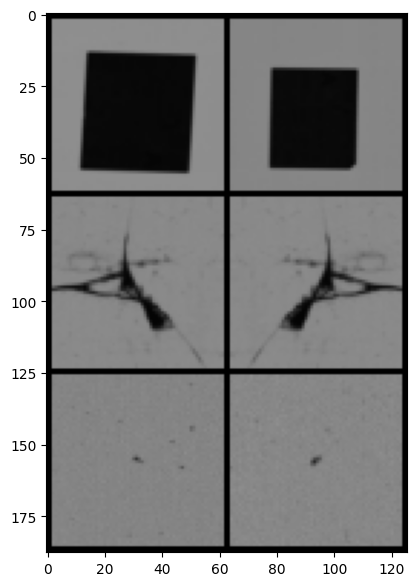

In [32]:
my_sample = extract_sample(3, 1, 1, test_x, test_y)
display_sample(my_sample['images'])
model = load_protonet_conv(
    x_dim=(3,60,60),
    hid_dim=64,
    z_dim=64,
)
my_loss, my_output, accuracy_dict = model.set_forward_loss(my_sample, accuracy_dict)
print_dictionary(accuracy_dict)
my_output

In [33]:
def train_test_pipeline(images_dict, split_percentage = 3/4, 
                        train_n_way = 3, train_n_support = 2, train_n_query = 1, train_epochs = 10, train_episodes = 50, 
                        test_n_way = 3, test_n_support = 1, test_n_query = 1, test_episodes = 50):
    
    train_x, train_y, test_x, test_y = split_train_test(images_dict, split_percentage)

    model = load_protonet_conv(
        x_dim=(3,60,60),
        hid_dim=64,
        z_dim=64,
    )

    optimizer = optim.Adam(model.parameters(), lr = 0.001)

    train_accuracy_dict, train_accuracy = train(model, optimizer, train_x, train_y, train_n_way, train_n_support, train_n_query, train_epochs, train_episodes)

    test_accuracy_dict, test_accuracy = test(model, test_x, test_y, test_n_way, test_n_support, test_n_query, test_episodes)

    print('----------------------------------------------')
    print('Train results')
    print_dictionary(train_accuracy_dict)
    print('----------------------------------------------')
    print('Test results')
    print_dictionary(test_accuracy_dict)

    return train_accuracy_dict, train_accuracy, test_accuracy_dict, test_accuracy

# Training and testing on different number of episodes

In [63]:
def plot_accuracies_dict(accuracies_dict, title):
    for dictionary in accuracies_dict:
        keys = list(dictionary.keys())
        values = list(dictionary.values())
        x = range(len(keys))
        values = [sum(sublist) / len(sublist) for sublist in values]

        plt.figure(figsize=(6, 4))
        plt.bar(x, values)
        plt.xticks(x, keys)
        plt.xticks(rotation=90)
        plt.xlabel('labels')
        plt.ylabel('recalls')
        plt.title(title)
        plt.show()

In [35]:
def plot_accuracies(increased_episodes, train_accuracies, test_accuracies):
    plt.plot(increased_episodes, train_accuracies, label='train_accuracies')
    plt.plot(increased_episodes, test_accuracies, label='test_accuracies')
    plt.xlabel('# of episodes')
    plt.ylabel('accuracy')
    plt.legend()
    plt.title('evolution of accuracy with # of episodes')
    plt.show()

In [36]:
images, images_classes, images_dict = extract_images('../data/img/')
images_dict = preprocess_images(images_dict, 11, 60)

In [108]:
def exec_multiple_episodes(episodes_list = [50, 100, 250, 500]):
    train_accuracies_dict, test_accuracies_dict = [], []
    train_accuracies, test_accuracies = [], []

    for episodes in episodes_list:
        train_accuracy_dict, train_accuracy, test_accuracy_dict, test_accuracy = train_test_pipeline(images_dict, train_episodes = episodes, test_episodes = episodes)
        train_accuracies_dict.append(train_accuracy_dict)
        test_accuracies_dict.append(test_accuracy_dict)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

    return episodes_list, train_accuracies_dict, test_accuracies_dict, train_accuracies, test_accuracies

In [109]:
episodes_list, train_accuracies_dict, test_accuracies_dict, train_accuracies, test_accuracies = exec_multiple_episodes()

20
8
20
20
20
20
20
20
20
20
20
20
20
20
20
-----
15
6
15
15
15
15
15
15
15
15
15
15
15
15
15
-----
5
2
5
5
5
5
5
5
5
5
5
5
5
5
5


C:\Users\matte\AppData\Local\Temp\ipykernel_4876\1451704302.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes, desc="Epoch {:d} train".format(epoch+1)):


Epoch 1 train:   0%|          | 0/50 [00:00<?, ?it/s]

K: ['break' 'glass_id' 'scratch_heavy']
Epoch 1 -- Loss: 1.1173 Acc: 0.0133
K: ['dust' 'glass_id' 'break']
Epoch 2 -- Loss: 3.9274 Acc: 0.0267
K: ['scratch_light' 'break' 'altro']
Epoch 3 -- Loss: 6.0081 Acc: 0.0333
K: ['break' 'scratch_light' 'glass_id']
Epoch 4 -- Loss: 6.0081 Acc: 0.0533
K: ['bubble_hole' 'dirt' 'scratch_heavy']
Epoch 5 -- Loss: 6.0099 Acc: 0.0733
K: ['scratch_multi' 'scratch_heavy' 'mark']
Epoch 6 -- Loss: 6.0099 Acc: 0.0933
K: ['bubble' 'halo' 'break']
Epoch 7 -- Loss: 6.7010 Acc: 0.1067
K: ['scratch_light' 'dirt_halo' 'coating']
Epoch 8 -- Loss: 6.7010 Acc: 0.1267
K: ['scratch_heavy' 'break' 'dust']
Epoch 9 -- Loss: 10.0074 Acc: 0.1400
K: ['bubble' 'scratch_light' 'mark']
Epoch 10 -- Loss: 10.2619 Acc: 0.1533
K: ['halo' 'glass_id' 'point']
Epoch 11 -- Loss: 10.2619 Acc: 0.1733
K: ['halo' 'point' 'dust']
Epoch 12 -- Loss: 10.3578 Acc: 0.1867
K: ['dirt_halo' 'scratch_heavy' 'bubble_hole']
Epoch 13 -- Loss: 13.4291 Acc: 0.1933
K: ['dirt_halo' 'halo' 'break']
Epoch 1

C:\Users\matte\AppData\Local\Temp\ipykernel_4876\2763146824.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes):


  0%|          | 0/50 [00:00<?, ?it/s]

K: ['scratch_multi' 'break' 'altro']
K: ['bubble_hole' 'scratch_heavy' 'bubble']
K: ['dirt_halo' 'break' 'point']
K: ['dirt_halo' 'break' 'scratch_heavy']
K: ['halo' 'point' 'break']
K: ['halo' 'coating' 'point']
K: ['scratch_light' 'scratch_multi' 'bubble']
K: ['break' 'glass_id' 'dirt_halo']
K: ['mark' 'dust' 'dirt_halo']
K: ['dirt_halo' 'point' 'scratch_heavy']
K: ['scratch_heavy' 'bubble_hole' 'coating']
K: ['dirt' 'mark' 'halo']
K: ['coating' 'mark' 'scratch_multi']
K: ['scratch_heavy' 'altro' 'dust']
K: ['altro' 'break' 'halo']
K: ['point' 'altro' 'dust']
K: ['scratch_multi' 'coating' 'scratch_light']
K: ['glass_id' 'point' 'bubble_hole']
K: ['halo' 'bubble_hole' 'dirt']
K: ['altro' 'dirt_halo' 'bubble']
K: ['altro' 'bubble' 'scratch_heavy']
K: ['bubble_hole' 'coating' 'dirt_halo']
K: ['scratch_multi' 'break' 'bubble_hole']
K: ['scratch_heavy' 'mark' 'halo']
K: ['scratch_heavy' 'coating' 'scratch_light']
K: ['dust' 'halo' 'dirt_halo']
K: ['halo' 'point' 'glass_id']
K: ['dust' 'sc

Epoch 1 train:   0%|          | 0/100 [00:00<?, ?it/s]

K: ['altro' 'coating' 'mark']
Epoch 1 -- Loss: 1.0119 Acc: 0.0067
K: ['scratch_heavy' 'bubble' 'halo']
Epoch 2 -- Loss: 1.0119 Acc: 0.0167
K: ['mark' 'glass_id' 'altro']
Epoch 3 -- Loss: 1.0119 Acc: 0.0267
K: ['bubble' 'altro' 'scratch_multi']
Epoch 4 -- Loss: 2.2455 Acc: 0.0333
K: ['dirt_halo' 'coating' 'altro']
Epoch 5 -- Loss: 2.6539 Acc: 0.0400
K: ['scratch_heavy' 'coating' 'dirt_halo']
Epoch 6 -- Loss: 2.7439 Acc: 0.0467
K: ['point' 'bubble_hole' 'altro']
Epoch 7 -- Loss: 2.8649 Acc: 0.0533
K: ['scratch_light' 'bubble_hole' 'point']
Epoch 8 -- Loss: 2.8649 Acc: 0.0633
K: ['coating' 'scratch_light' 'point']
Epoch 9 -- Loss: 2.8649 Acc: 0.0733
K: ['mark' 'break' 'glass_id']
Epoch 10 -- Loss: 2.8649 Acc: 0.0833
K: ['altro' 'bubble_hole' 'scratch_multi']
Epoch 11 -- Loss: 3.1387 Acc: 0.0867
K: ['mark' 'dirt' 'coating']
Epoch 12 -- Loss: 3.1387 Acc: 0.0967
K: ['coating' 'dust' 'scratch_heavy']
Epoch 13 -- Loss: 3.7732 Acc: 0.1033
K: ['halo' 'bubble' 'break']
Epoch 14 -- Loss: 4.5902 Ac

  0%|          | 0/100 [00:00<?, ?it/s]

K: ['dirt' 'coating' 'scratch_multi']
K: ['scratch_light' 'halo' 'point']
K: ['glass_id' 'halo' 'bubble_hole']
K: ['scratch_light' 'dirt' 'break']
K: ['scratch_heavy' 'point' 'glass_id']
K: ['scratch_heavy' 'altro' 'scratch_multi']
K: ['mark' 'coating' 'scratch_light']
K: ['dirt' 'break' 'glass_id']
K: ['halo' 'coating' 'glass_id']
K: ['bubble' 'break' 'dirt_halo']
K: ['scratch_light' 'halo' 'glass_id']
K: ['dirt_halo' 'glass_id' 'coating']
K: ['mark' 'scratch_multi' 'altro']
K: ['bubble_hole' 'mark' 'glass_id']
K: ['halo' 'bubble' 'break']
K: ['dust' 'dirt_halo' 'altro']
K: ['scratch_light' 'halo' 'bubble']
K: ['point' 'altro' 'dust']
K: ['scratch_heavy' 'dirt_halo' 'altro']
K: ['point' 'dirt_halo' 'bubble']
K: ['halo' 'coating' 'scratch_heavy']
K: ['halo' 'dirt_halo' 'dirt']
K: ['dirt' 'glass_id' 'break']
K: ['bubble' 'glass_id' 'mark']
K: ['altro' 'break' 'coating']
K: ['mark' 'coating' 'dust']
K: ['dirt_halo' 'mark' 'point']
K: ['glass_id' 'bubble' 'coating']
K: ['scratch_heavy' 'g

Epoch 1 train:   0%|          | 0/250 [00:00<?, ?it/s]

K: ['dust' 'dirt' 'bubble']
Epoch 1 -- Loss: 0.3369 Acc: 0.0000
K: ['mark' 'point' 'halo']
Epoch 2 -- Loss: 0.3369 Acc: 0.0040
K: ['point' 'dirt_halo' 'scratch_multi']
Epoch 3 -- Loss: 0.6493 Acc: 0.0053
K: ['scratch_heavy' 'mark' 'scratch_multi']
Epoch 4 -- Loss: 0.9654 Acc: 0.0080
K: ['dirt_halo' 'bubble_hole' 'point']
Epoch 5 -- Loss: 0.9654 Acc: 0.0120
K: ['break' 'coating' 'scratch_multi']
Epoch 6 -- Loss: 1.4035 Acc: 0.0147
K: ['dirt' 'scratch_light' 'altro']
Epoch 7 -- Loss: 1.8451 Acc: 0.0160
K: ['coating' 'dust' 'scratch_multi']
Epoch 8 -- Loss: 2.3021 Acc: 0.0187
K: ['altro' 'glass_id' 'mark']
Epoch 9 -- Loss: 2.4674 Acc: 0.0200
K: ['scratch_light' 'bubble_hole' 'dirt']
Epoch 10 -- Loss: 3.0970 Acc: 0.0213
K: ['scratch_light' 'break' 'bubble']
Epoch 11 -- Loss: 3.6182 Acc: 0.0240
K: ['coating' 'dirt_halo' 'altro']
Epoch 12 -- Loss: 3.7220 Acc: 0.0267
K: ['point' 'mark' 'altro']
Epoch 13 -- Loss: 3.7220 Acc: 0.0307
K: ['coating' 'dust' 'mark']
Epoch 14 -- Loss: 3.7220 Acc: 0.0

  0%|          | 0/250 [00:00<?, ?it/s]

K: ['glass_id' 'break' 'dirt_halo']
K: ['dust' 'glass_id' 'dirt_halo']
K: ['dirt' 'halo' 'coating']
K: ['scratch_multi' 'scratch_light' 'dust']
K: ['coating' 'dirt' 'bubble_hole']
K: ['glass_id' 'scratch_light' 'coating']
K: ['dirt' 'halo' 'scratch_multi']
K: ['dust' 'scratch_multi' 'coating']
K: ['scratch_heavy' 'scratch_multi' 'dirt_halo']
K: ['bubble' 'scratch_heavy' 'break']
K: ['mark' 'glass_id' 'dust']
K: ['scratch_multi' 'glass_id' 'halo']
K: ['dirt_halo' 'break' 'scratch_multi']
K: ['halo' 'coating' 'mark']
K: ['scratch_heavy' 'dirt' 'dirt_halo']
K: ['altro' 'dust' 'bubble_hole']
K: ['dirt_halo' 'dust' 'dirt']
K: ['scratch_light' 'point' 'dust']
K: ['halo' 'scratch_multi' 'scratch_light']
K: ['scratch_light' 'dirt' 'mark']
K: ['altro' 'dirt' 'bubble_hole']
K: ['dirt' 'dirt_halo' 'bubble']
K: ['mark' 'glass_id' 'scratch_multi']
K: ['dirt_halo' 'point' 'bubble_hole']
K: ['break' 'scratch_light' 'scratch_multi']
K: ['point' 'dirt' 'scratch_multi']
K: ['bubble_hole' 'point' 'glass_

Epoch 1 train:   0%|          | 0/500 [00:00<?, ?it/s]

K: ['point' 'scratch_heavy' 'glass_id']
Epoch 1 -- Loss: 0.1389 Acc: 0.0013
K: ['break' 'bubble' 'bubble_hole']
Epoch 2 -- Loss: 0.3329 Acc: 0.0027
K: ['dirt' 'break' 'scratch_heavy']
Epoch 3 -- Loss: 0.4474 Acc: 0.0033
K: ['altro' 'bubble' 'scratch_multi']
Epoch 4 -- Loss: 0.4489 Acc: 0.0047
K: ['dust' 'scratch_light' 'halo']
Epoch 5 -- Loss: 0.6281 Acc: 0.0053
K: ['bubble' 'scratch_multi' 'mark']
Epoch 6 -- Loss: 0.6281 Acc: 0.0073
K: ['coating' 'mark' 'halo']
Epoch 7 -- Loss: 0.6281 Acc: 0.0093
K: ['glass_id' 'coating' 'dirt_halo']
Epoch 8 -- Loss: 0.6281 Acc: 0.0113
K: ['dust' 'mark' 'coating']
Epoch 9 -- Loss: 0.6713 Acc: 0.0127
K: ['break' 'dirt_halo' 'dust']
Epoch 10 -- Loss: 0.6854 Acc: 0.0140
K: ['coating' 'mark' 'bubble_hole']
Epoch 11 -- Loss: 0.6854 Acc: 0.0160
K: ['halo' 'point' 'mark']
Epoch 12 -- Loss: 0.6854 Acc: 0.0180
K: ['break' 'coating' 'dust']
Epoch 13 -- Loss: 0.6854 Acc: 0.0200
K: ['scratch_heavy' 'dirt' 'altro']
Epoch 14 -- Loss: 0.7490 Acc: 0.0213
K: ['point' 

  0%|          | 0/500 [00:00<?, ?it/s]

K: ['dirt' 'bubble' 'scratch_light']
K: ['bubble_hole' 'dirt_halo' 'dirt']
K: ['glass_id' 'altro' 'coating']
K: ['dust' 'dirt_halo' 'point']
K: ['scratch_multi' 'bubble_hole' 'coating']
K: ['dirt' 'scratch_heavy' 'coating']
K: ['halo' 'dirt_halo' 'break']
K: ['mark' 'altro' 'bubble_hole']
K: ['dust' 'glass_id' 'mark']
K: ['halo' 'scratch_multi' 'dirt_halo']
K: ['scratch_light' 'glass_id' 'bubble_hole']
K: ['coating' 'dirt_halo' 'scratch_multi']
K: ['dirt_halo' 'glass_id' 'bubble_hole']
K: ['dirt_halo' 'bubble_hole' 'bubble']
K: ['bubble_hole' 'dirt_halo' 'dust']
K: ['bubble_hole' 'scratch_heavy' 'coating']
K: ['break' 'coating' 'scratch_light']
K: ['dust' 'break' 'mark']
K: ['break' 'point' 'scratch_heavy']
K: ['bubble' 'altro' 'scratch_heavy']
K: ['break' 'dust' 'glass_id']
K: ['scratch_heavy' 'halo' 'glass_id']
K: ['bubble_hole' 'point' 'coating']
K: ['coating' 'dust' 'break']
K: ['altro' 'scratch_light' 'dirt_halo']
K: ['bubble_hole' 'dust' 'glass_id']
K: ['bubble_hole' 'scratch_lig

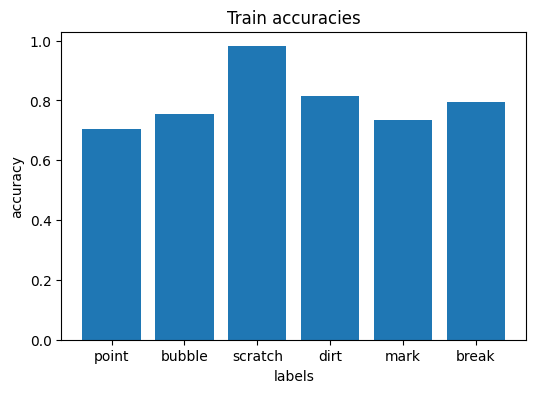

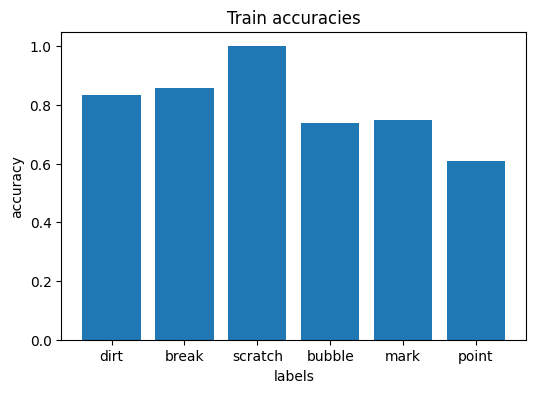

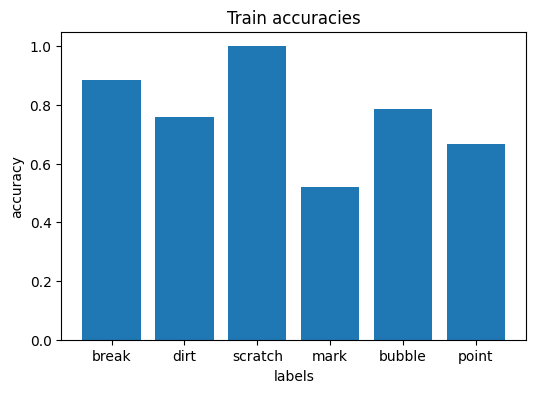

In [64]:
plot_accuracies_dict(train_accuracies_dict, 'Train recalls')

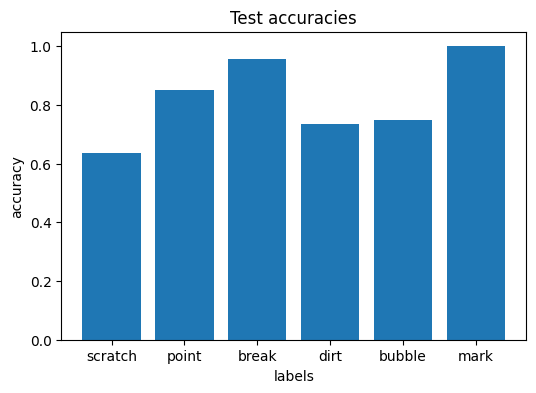

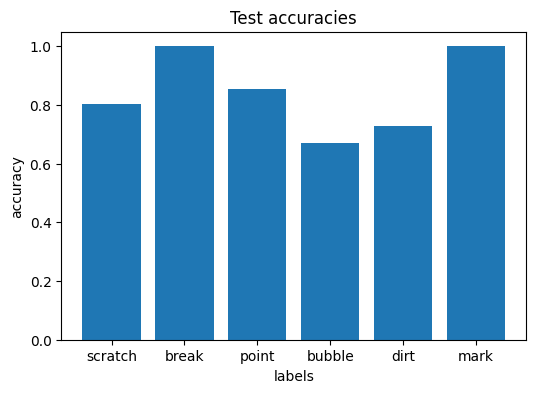

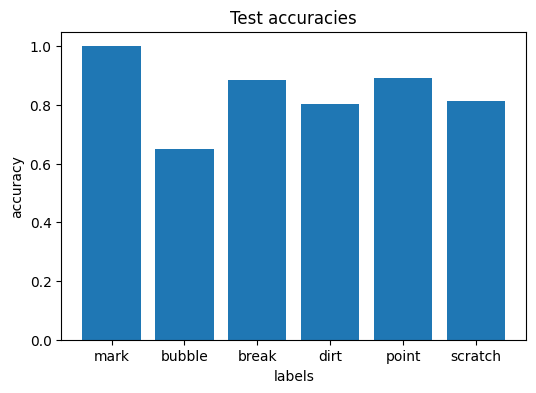

In [65]:
plot_accuracies_dict(test_accuracies_dict, 'Test recalls')

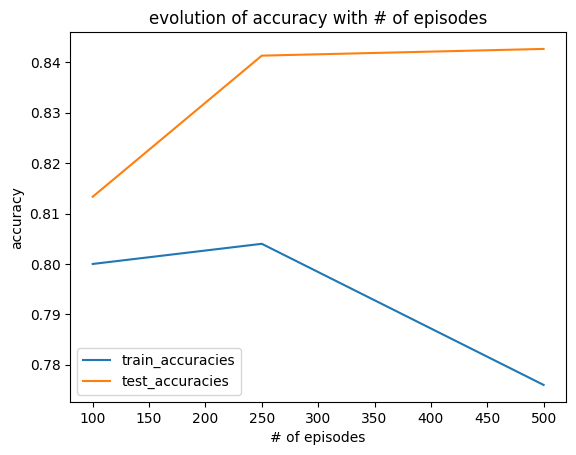

In [66]:
plot_accuracies(episodes_list, train_accuracies, test_accuracies)

# Using default dataset + background (opt_bckg)

In [67]:
images, images_classes, images_dict = extract_images('../data/views_opt_bckg/img/')

In [68]:
classes = set(images_classes)
len(images), len(images_classes), len(classes)

(31, 31, 7)

In [69]:
classes

{'background', 'break', 'bubble', 'dirt', 'mark', 'point', 'scratch'}

In [70]:
images_dict = preprocess_images(images_dict, 26, 60)
target_classes = extend_target_classes(images_classes, 4)

In [71]:
train_test_pipeline(images_dict)

20
8
20
20
16
20
20
-----
15
6
15
15
12
15
15
-----
5
2
5
5
4
5
5


C:\Users\matte\AppData\Local\Temp\ipykernel_4876\1451704302.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes, desc="Epoch {:d} train".format(epoch+1)):


Epoch 1 train:   0%|          | 0/50 [00:00<?, ?it/s]

K: ['point' 'break' 'mark']


Epoch 1 -- Loss: 0.0000 Acc: 0.0200
K: ['scratch' 'bubble' 'break']
Epoch 2 -- Loss: 0.0000 Acc: 0.0400
K: ['point' 'dirt' 'mark']
Epoch 3 -- Loss: 0.2501 Acc: 0.0533
K: ['break' 'dirt' 'point']
Epoch 4 -- Loss: 0.2504 Acc: 0.0733
K: ['point' 'mark' 'break']
Epoch 5 -- Loss: 0.2504 Acc: 0.0933
K: ['bubble' 'point' 'break']
Epoch 6 -- Loss: 0.4408 Acc: 0.1067
K: ['bubble' 'break' 'scratch']
Epoch 7 -- Loss: 0.5196 Acc: 0.1200
K: ['point' 'break' 'dirt']
Epoch 8 -- Loss: 0.5196 Acc: 0.1400
K: ['break' 'point' 'bubble']
Epoch 9 -- Loss: 0.5204 Acc: 0.1600
K: ['bubble' 'break' 'dirt']
Epoch 10 -- Loss: 0.5204 Acc: 0.1800
K: ['point' 'mark' 'background']
Epoch 11 -- Loss: 2.4330 Acc: 0.1933
K: ['break' 'scratch' 'background']
Epoch 12 -- Loss: 4.9690 Acc: 0.2000
K: ['scratch' 'mark' 'break']
Epoch 13 -- Loss: 5.2585 Acc: 0.2133
K: ['point' 'scratch' 'mark']
Epoch 14 -- Loss: 5.2585 Acc: 0.2333
K: ['mark' 'break' 'bubble']
Epoch 15 -- Loss: 5.2585 Acc: 0.2533
K: ['scratch' 'bubble' 'point']


C:\Users\matte\AppData\Local\Temp\ipykernel_4876\2763146824.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes):


  0%|          | 0/50 [00:00<?, ?it/s]

K: ['point' 'mark' 'background']
K: ['mark' 'bubble' 'background']
K: ['scratch' 'dirt' 'mark']
K: ['break' 'scratch' 'point']
K: ['point' 'dirt' 'background']
K: ['point' 'break' 'mark']
K: ['break' 'mark' 'point']
K: ['dirt' 'background' 'scratch']
K: ['break' 'scratch' 'bubble']
K: ['scratch' 'point' 'dirt']
K: ['point' 'bubble' 'dirt']
K: ['break' 'point' 'mark']
K: ['dirt' 'background' 'bubble']
K: ['bubble' 'point' 'scratch']
K: ['dirt' 'mark' 'bubble']
K: ['break' 'bubble' 'scratch']
K: ['bubble' 'background' 'mark']
K: ['break' 'mark' 'bubble']
K: ['scratch' 'background' 'point']
K: ['bubble' 'point' 'dirt']
K: ['mark' 'point' 'break']
K: ['dirt' 'break' 'bubble']
K: ['scratch' 'mark' 'break']
K: ['scratch' 'dirt' 'point']
K: ['background' 'mark' 'point']
K: ['break' 'scratch' 'dirt']
K: ['bubble' 'point' 'dirt']
K: ['bubble' 'background' 'dirt']
K: ['background' 'break' 'dirt']
K: ['dirt' 'scratch' 'mark']
K: ['background' 'mark' 'dirt']
K: ['break' 'background' 'dirt']
K: ['m

({'point': [1.0,
   0.0,
   1.0,
   1.0,
   0.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0],
  'break': [1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0],
  'mark': [1.0,
   1.0,
   1.0,
   1.0,
   0.0,
   1.0,
   1.0,
   0.0,
   1.0,
   1.0,
   1.0,
   0.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0],
  'scratch': [1.0,
   1.0,
   0.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.0,
   1.0],
  'bubble': [1.0,
   1.0,
   0.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0],
  'dirt': [1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1

# Training and testing on different number of episodes

In [72]:
episodes_list, train_accuracies_dict, test_accuracies_dict, train_accuracies, test_accuracies = exec_multiple_episodes()

20
8
20
20
16
20
20
-----
15
6
15
15
12
15
15
-----
5
2
5
5
4
5
5


C:\Users\matte\AppData\Local\Temp\ipykernel_4876\1451704302.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes, desc="Epoch {:d} train".format(epoch+1)):


Epoch 1 train:   0%|          | 0/100 [00:00<?, ?it/s]

K: ['dirt' 'break' 'mark']
Epoch 1 -- Loss: 0.4763 Acc: 0.0067
K: ['dirt' 'bubble' 'mark']
Epoch 2 -- Loss: 0.4763 Acc: 0.0167
K: ['point' 'mark' 'bubble']
Epoch 3 -- Loss: 0.5986 Acc: 0.0233
K: ['bubble' 'scratch' 'break']
Epoch 4 -- Loss: 0.5986 Acc: 0.0333
K: ['bubble' 'break' 'background']
Epoch 5 -- Loss: 0.5986 Acc: 0.0433
K: ['background' 'dirt' 'point']
Epoch 6 -- Loss: 1.9431 Acc: 0.0433
K: ['break' 'scratch' 'dirt']
Epoch 7 -- Loss: 2.0738 Acc: 0.0500
K: ['bubble' 'point' 'dirt']
Epoch 8 -- Loss: 2.4797 Acc: 0.0567
K: ['mark' 'scratch' 'point']
Epoch 9 -- Loss: 2.4797 Acc: 0.0667
K: ['point' 'break' 'bubble']
Epoch 10 -- Loss: 2.5697 Acc: 0.0733
K: ['point' 'break' 'bubble']
Epoch 11 -- Loss: 2.6793 Acc: 0.0767
K: ['dirt' 'background' 'mark']
Epoch 12 -- Loss: 3.6398 Acc: 0.0833
K: ['break' 'mark' 'background']
Epoch 13 -- Loss: 3.6398 Acc: 0.0933
K: ['mark' 'point' 'bubble']
Epoch 14 -- Loss: 3.8969 Acc: 0.0967
K: ['point' 'background' 'break']
Epoch 15 -- Loss: 3.8969 Acc: 

C:\Users\matte\AppData\Local\Temp\ipykernel_4876\2763146824.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes):


  0%|          | 0/100 [00:00<?, ?it/s]

K: ['bubble' 'dirt' 'background']
K: ['point' 'break' 'dirt']
K: ['background' 'break' 'point']
K: ['bubble' 'dirt' 'background']
K: ['mark' 'dirt' 'point']
K: ['break' 'point' 'background']
K: ['mark' 'bubble' 'scratch']
K: ['break' 'mark' 'point']
K: ['dirt' 'background' 'scratch']
K: ['point' 'scratch' 'bubble']
K: ['break' 'scratch' 'dirt']
K: ['scratch' 'break' 'mark']
K: ['point' 'background' 'dirt']
K: ['background' 'scratch' 'dirt']
K: ['scratch' 'point' 'dirt']
K: ['scratch' 'mark' 'bubble']
K: ['scratch' 'break' 'background']
K: ['background' 'point' 'mark']
K: ['bubble' 'break' 'background']
K: ['bubble' 'scratch' 'mark']
K: ['dirt' 'mark' 'bubble']
K: ['background' 'break' 'point']
K: ['break' 'point' 'bubble']
K: ['break' 'background' 'point']
K: ['dirt' 'break' 'point']
K: ['background' 'break' 'dirt']
K: ['background' 'scratch' 'break']
K: ['bubble' 'mark' 'point']
K: ['point' 'break' 'dirt']
K: ['mark' 'background' 'break']
K: ['dirt' 'background' 'bubble']
K: ['bubble'

Epoch 1 train:   0%|          | 0/250 [00:00<?, ?it/s]

K: ['dirt' 'break' 'scratch']
Epoch 1 -- Loss: 0.0000 Acc: 0.0040
K: ['break' 'dirt' 'mark']
Epoch 2 -- Loss: 0.0783 Acc: 0.0067
K: ['dirt' 'break' 'mark']
Epoch 3 -- Loss: 0.1377 Acc: 0.0093
K: ['break' 'mark' 'point']
Epoch 4 -- Loss: 0.1377 Acc: 0.0133
K: ['break' 'bubble' 'scratch']
Epoch 5 -- Loss: 0.1547 Acc: 0.0160
K: ['mark' 'bubble' 'point']
Epoch 6 -- Loss: 0.1547 Acc: 0.0200
K: ['break' 'background' 'bubble']
Epoch 7 -- Loss: 0.8052 Acc: 0.0227
K: ['point' 'background' 'mark']
Epoch 8 -- Loss: 1.3626 Acc: 0.0253
K: ['break' 'point' 'mark']
Epoch 9 -- Loss: 1.3626 Acc: 0.0293
K: ['dirt' 'background' 'bubble']
Epoch 10 -- Loss: 2.0159 Acc: 0.0307
K: ['break' 'mark' 'scratch']
Epoch 11 -- Loss: 2.1462 Acc: 0.0333
K: ['mark' 'bubble' 'scratch']
Epoch 12 -- Loss: 2.1462 Acc: 0.0373
K: ['break' 'background' 'dirt']
Epoch 13 -- Loss: 2.5717 Acc: 0.0400
K: ['dirt' 'bubble' 'scratch']
Epoch 14 -- Loss: 2.6077 Acc: 0.0427
K: ['break' 'bubble' 'scratch']
Epoch 15 -- Loss: 2.6077 Acc: 0

  0%|          | 0/250 [00:00<?, ?it/s]

K: ['bubble' 'mark' 'dirt']
K: ['point' 'break' 'dirt']
K: ['scratch' 'dirt' 'mark']
K: ['break' 'scratch' 'mark']
K: ['scratch' 'background' 'dirt']
K: ['point' 'scratch' 'bubble']
K: ['bubble' 'dirt' 'scratch']
K: ['point' 'bubble' 'dirt']
K: ['break' 'bubble' 'dirt']
K: ['point' 'dirt' 'scratch']
K: ['scratch' 'break' 'point']
K: ['scratch' 'mark' 'bubble']
K: ['bubble' 'background' 'mark']
K: ['bubble' 'break' 'scratch']
K: ['break' 'point' 'scratch']
K: ['point' 'dirt' 'bubble']
K: ['dirt' 'background' 'bubble']
K: ['bubble' 'point' 'background']
K: ['dirt' 'background' 'point']
K: ['break' 'bubble' 'mark']
K: ['mark' 'background' 'break']
K: ['break' 'mark' 'point']
K: ['dirt' 'point' 'scratch']
K: ['scratch' 'point' 'break']
K: ['background' 'dirt' 'scratch']
K: ['bubble' 'break' 'mark']
K: ['mark' 'point' 'scratch']
K: ['dirt' 'point' 'mark']
K: ['scratch' 'dirt' 'background']
K: ['bubble' 'background' 'scratch']
K: ['scratch' 'mark' 'bubble']
K: ['break' 'scratch' 'mark']
K: [

Epoch 1 train:   0%|          | 0/500 [00:00<?, ?it/s]

K: ['background' 'bubble' 'point']
Epoch 1 -- Loss: 0.0384 Acc: 0.0013
K: ['scratch' 'break' 'bubble']
Epoch 2 -- Loss: 0.0384 Acc: 0.0033
K: ['point' 'scratch' 'background']
Epoch 3 -- Loss: 0.5142 Acc: 0.0040
K: ['mark' 'dirt' 'scratch']
Epoch 4 -- Loss: 0.5142 Acc: 0.0060
K: ['mark' 'break' 'scratch']
Epoch 5 -- Loss: 0.5142 Acc: 0.0080
K: ['break' 'dirt' 'mark']
Epoch 6 -- Loss: 0.5142 Acc: 0.0100
K: ['bubble' 'mark' 'break']
Epoch 7 -- Loss: 0.5626 Acc: 0.0113
K: ['background' 'scratch' 'dirt']
Epoch 8 -- Loss: 0.8589 Acc: 0.0127
K: ['point' 'background' 'break']
Epoch 9 -- Loss: 0.8589 Acc: 0.0147
K: ['scratch' 'point' 'background']
Epoch 10 -- Loss: 1.0108 Acc: 0.0153
K: ['background' 'bubble' 'point']
Epoch 11 -- Loss: 1.0167 Acc: 0.0167
K: ['background' 'dirt' 'mark']
Epoch 12 -- Loss: 1.2570 Acc: 0.0180
K: ['point' 'bubble' 'dirt']
Epoch 13 -- Loss: 1.2570 Acc: 0.0200
K: ['dirt' 'point' 'mark']
Epoch 14 -- Loss: 1.2570 Acc: 0.0220
K: ['point' 'scratch' 'background']
Epoch 15 

  0%|          | 0/500 [00:00<?, ?it/s]

K: ['dirt' 'break' 'bubble']
K: ['mark' 'background' 'point']
K: ['scratch' 'mark' 'bubble']
K: ['break' 'mark' 'background']
K: ['bubble' 'scratch' 'point']
K: ['break' 'mark' 'dirt']
K: ['bubble' 'background' 'scratch']
K: ['dirt' 'mark' 'point']
K: ['background' 'scratch' 'break']
K: ['bubble' 'dirt' 'break']
K: ['bubble' 'background' 'mark']
K: ['scratch' 'dirt' 'break']
K: ['mark' 'scratch' 'break']
K: ['dirt' 'background' 'break']
K: ['point' 'dirt' 'background']
K: ['dirt' 'background' 'point']
K: ['background' 'dirt' 'bubble']
K: ['point' 'mark' 'background']
K: ['bubble' 'break' 'dirt']
K: ['dirt' 'break' 'point']
K: ['bubble' 'dirt' 'background']
K: ['scratch' 'mark' 'background']
K: ['break' 'mark' 'dirt']
K: ['mark' 'scratch' 'background']
K: ['break' 'background' 'scratch']
K: ['scratch' 'background' 'point']
K: ['mark' 'dirt' 'break']
K: ['mark' 'dirt' 'bubble']
K: ['scratch' 'background' 'mark']
K: ['mark' 'break' 'dirt']
K: ['break' 'mark' 'dirt']
K: ['dirt' 'mark' 'poi

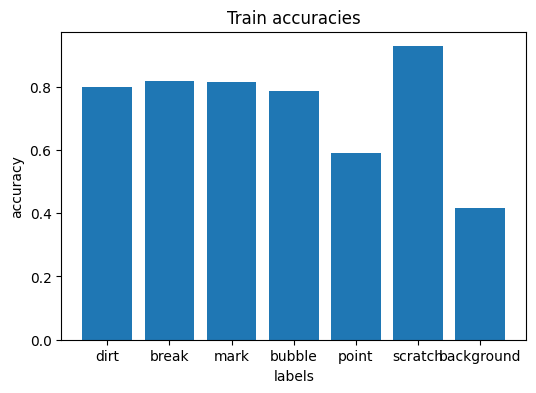

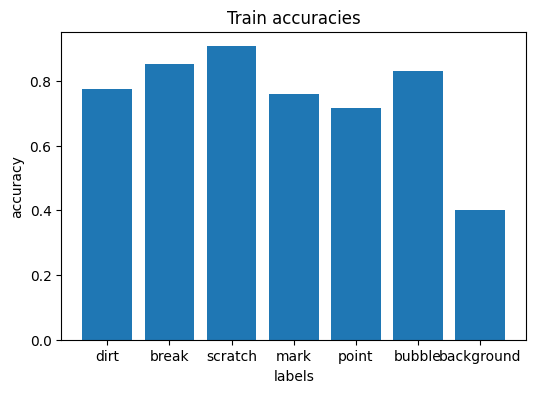

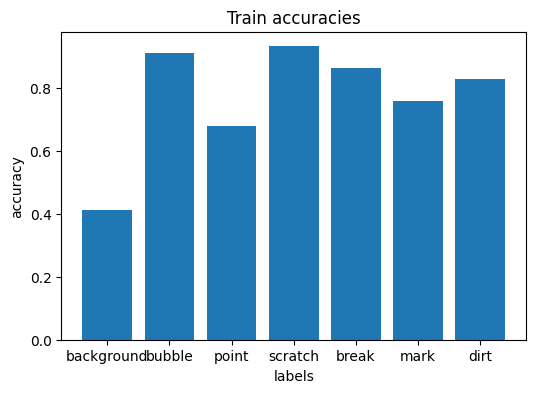

In [73]:
plot_accuracies_dict(train_accuracies_dict, 'Train recalls')

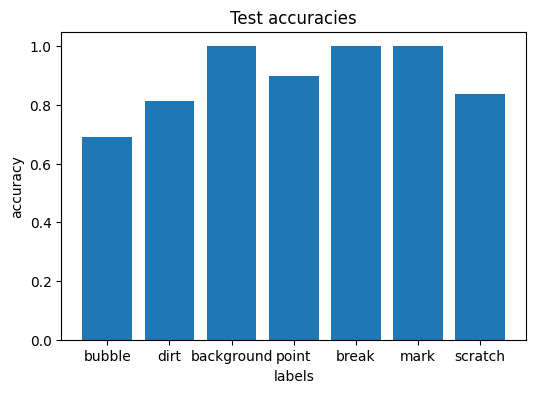

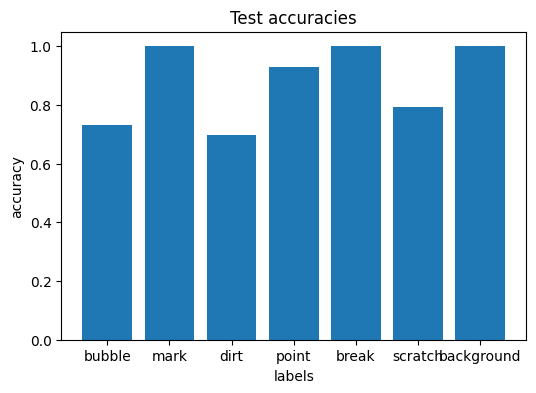

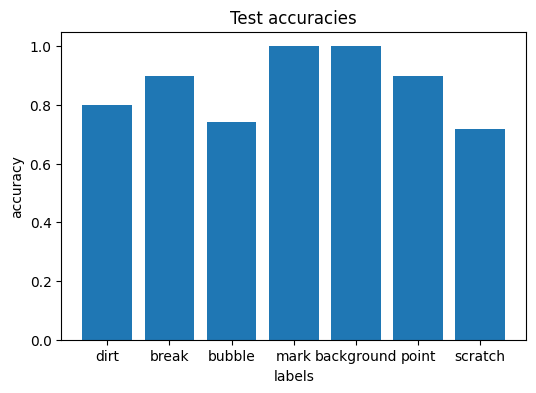

In [74]:
plot_accuracies_dict(test_accuracies_dict, 'Test recalls')

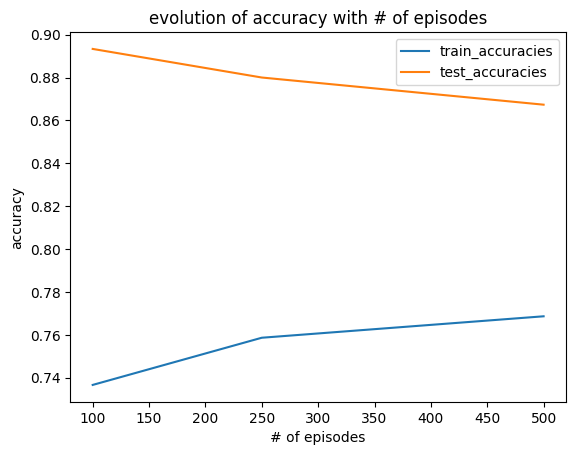

In [75]:
plot_accuracies(episodes_list, train_accuracies, test_accuracies)

# Using qplus dataset (general classes)

In [76]:
images, images_classes, images_dict = extract_images('../data/views_qplus/img/')

In [77]:
classes = set(images_classes)
len(images), len(images_classes), len(classes)

(52, 52, 11)

In [78]:
classes

{'altro',
 'break',
 'bubble',
 'coating',
 'dirt',
 'dust',
 'glass',
 'halo',
 'mark',
 'point',
 'scratch'}

In [79]:
images_dict = preprocess_images(images_dict, 23, 60)
target_classes = extend_target_classes(images_classes, 4)

In [80]:
train_test_pipeline(images_dict)

20
8
20
20
20
20
20
20
20
20
20
-----
15
6
15
15
15
15
15
15
15
15
15
-----
5
2
5
5
5
5
5
5
5
5
5


C:\Users\matte\AppData\Local\Temp\ipykernel_4876\1451704302.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes, desc="Epoch {:d} train".format(epoch+1)):


Epoch 1 train:   0%|          | 0/50 [00:00<?, ?it/s]

K: ['mark' 'dust' 'coating']
Epoch 1 -- Loss: 1.2746 Acc: 0.0133
K: ['coating' 'scratch' 'altro']
Epoch 2 -- Loss: 3.0161 Acc: 0.0267
K: ['mark' 'coating' 'scratch']
Epoch 3 -- Loss: 3.0161 Acc: 0.0467
K: ['break' 'scratch' 'dust']
Epoch 4 -- Loss: 6.5012 Acc: 0.0600
K: ['dirt' 'scratch' 'halo']
Epoch 5 -- Loss: 6.8838 Acc: 0.0733
K: ['mark' 'halo' 'break']
Epoch 6 -- Loss: 7.4186 Acc: 0.0867
K: ['point' 'coating' 'break']
Epoch 7 -- Loss: 8.5940 Acc: 0.1000
K: ['altro' 'coating' 'dirt']
Epoch 8 -- Loss: 8.7391 Acc: 0.1133
K: ['glass' 'halo' 'point']
Epoch 9 -- Loss: 8.7395 Acc: 0.1333
K: ['dust' 'point' 'halo']
Epoch 10 -- Loss: 8.7574 Acc: 0.1467
K: ['dirt' 'dust' 'coating']
Epoch 11 -- Loss: 8.7574 Acc: 0.1667
K: ['coating' 'bubble' 'altro']
Epoch 12 -- Loss: 8.7574 Acc: 0.1867
K: ['glass' 'halo' 'dirt']
Epoch 13 -- Loss: 9.2900 Acc: 0.2000
K: ['break' 'mark' 'coating']
Epoch 14 -- Loss: 9.2902 Acc: 0.2200
K: ['scratch' 'break' 'mark']
Epoch 15 -- Loss: 9.5545 Acc: 0.2333
K: ['dust'

C:\Users\matte\AppData\Local\Temp\ipykernel_4876\2763146824.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes):


  0%|          | 0/50 [00:00<?, ?it/s]

K: ['mark' 'scratch' 'dust']
K: ['break' 'dirt' 'bubble']
K: ['halo' 'altro' 'glass']
K: ['glass' 'dirt' 'mark']
K: ['bubble' 'point' 'scratch']
K: ['glass' 'bubble' 'scratch']
K: ['dirt' 'coating' 'mark']
K: ['scratch' 'altro' 'glass']
K: ['bubble' 'coating' 'point']
K: ['point' 'halo' 'coating']
K: ['mark' 'glass' 'coating']
K: ['break' 'coating' 'bubble']
K: ['scratch' 'altro' 'halo']
K: ['altro' 'dust' 'point']
K: ['halo' 'mark' 'bubble']
K: ['dirt' 'point' 'coating']
K: ['halo' 'bubble' 'glass']
K: ['mark' 'break' 'glass']
K: ['dust' 'altro' 'halo']
K: ['altro' 'dirt' 'bubble']
K: ['dust' 'mark' 'point']
K: ['glass' 'dirt' 'bubble']
K: ['mark' 'coating' 'scratch']
K: ['bubble' 'coating' 'altro']
K: ['break' 'mark' 'point']
K: ['bubble' 'dirt' 'point']
K: ['dirt' 'break' 'coating']
K: ['altro' 'coating' 'dirt']
K: ['bubble' 'dirt' 'mark']
K: ['coating' 'point' 'glass']
K: ['halo' 'scratch' 'mark']
K: ['dirt' 'mark' 'break']
K: ['dirt' 'scratch' 'break']
K: ['mark' 'halo' 'dust']
K:

({'mark': [0.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.0,
   0.0,
   1.0,
   1.0,
   0.0,
   1.0,
   1.0],
  'dust': [1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0],
  'coating': [1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0],
  'scratch': [0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
  'altro': [1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0],
  'break': [1.0,
   0.0,
   0.0,
   1.0,
   1.0,
   0.0,
   1.0,
   1.0,
   1.0,
   0.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0],
  'dirt': [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0],
  'halo': [1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  'point': [1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0],
  'glass': [1.0, 1.

# Training and testing on different number of episodes

In [81]:
episodes_list, train_accuracies_dict, test_accuracies_dict, train_accuracies, test_accuracies = exec_multiple_episodes()

20
8
20
20
20
20
20
20
20
20
20
-----
15
6
15
15
15
15
15
15
15
15
15
-----
5
2
5
5
5
5
5
5
5
5
5


C:\Users\matte\AppData\Local\Temp\ipykernel_4876\1451704302.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes, desc="Epoch {:d} train".format(epoch+1)):


Epoch 1 train:   0%|          | 0/100 [00:00<?, ?it/s]

K: ['mark' 'point' 'coating']
Epoch 1 -- Loss: 1.4224 Acc: 0.0067
K: ['point' 'dirt' 'dust']
Epoch 2 -- Loss: 1.5974 Acc: 0.0100
K: ['altro' 'glass' 'scratch']
Epoch 3 -- Loss: 1.7131 Acc: 0.0167
K: ['bubble' 'coating' 'scratch']
Epoch 4 -- Loss: 1.7131 Acc: 0.0267
K: ['halo' 'coating' 'dirt']
Epoch 5 -- Loss: 1.7131 Acc: 0.0367
K: ['point' 'mark' 'dirt']
Epoch 6 -- Loss: 1.8542 Acc: 0.0433
K: ['mark' 'point' 'bubble']
Epoch 7 -- Loss: 3.2137 Acc: 0.0467
K: ['coating' 'bubble' 'point']
Epoch 8 -- Loss: 4.0711 Acc: 0.0500
K: ['bubble' 'altro' 'dirt']
Epoch 9 -- Loss: 4.1169 Acc: 0.0567
K: ['point' 'glass' 'dust']
Epoch 10 -- Loss: 4.1169 Acc: 0.0667
K: ['dirt' 'scratch' 'dust']
Epoch 11 -- Loss: 4.1588 Acc: 0.0733
K: ['halo' 'dirt' 'dust']
Epoch 12 -- Loss: 4.6702 Acc: 0.0767
K: ['dirt' 'altro' 'glass']
Epoch 13 -- Loss: 5.2990 Acc: 0.0800
K: ['mark' 'dirt' 'dust']
Epoch 14 -- Loss: 5.3281 Acc: 0.0867
K: ['glass' 'bubble' 'coating']
Epoch 15 -- Loss: 5.3281 Acc: 0.0967
K: ['dust' 'halo'

C:\Users\matte\AppData\Local\Temp\ipykernel_4876\2763146824.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes):


  0%|          | 0/100 [00:00<?, ?it/s]

K: ['dirt' 'break' 'halo']
K: ['altro' 'point' 'coating']
K: ['coating' 'dust' 'scratch']
K: ['dust' 'scratch' 'mark']
K: ['halo' 'coating' 'glass']
K: ['halo' 'bubble' 'altro']
K: ['bubble' 'dirt' 'mark']
K: ['dust' 'bubble' 'break']
K: ['dirt' 'dust' 'altro']
K: ['halo' 'altro' 'glass']
K: ['altro' 'dirt' 'mark']
K: ['dust' 'point' 'altro']
K: ['point' 'dirt' 'coating']
K: ['bubble' 'glass' 'mark']
K: ['glass' 'coating' 'dust']
K: ['point' 'altro' 'dirt']
K: ['dust' 'scratch' 'coating']
K: ['glass' 'dirt' 'bubble']
K: ['halo' 'dust' 'point']
K: ['coating' 'bubble' 'halo']
K: ['coating' 'bubble' 'altro']
K: ['glass' 'dirt' 'bubble']
K: ['dirt' 'coating' 'bubble']
K: ['halo' 'bubble' 'mark']
K: ['glass' 'mark' 'halo']
K: ['dirt' 'bubble' 'mark']
K: ['coating' 'point' 'dust']
K: ['coating' 'point' 'bubble']
K: ['bubble' 'dust' 'coating']
K: ['glass' 'dust' 'point']
K: ['point' 'dirt' 'mark']
K: ['glass' 'dust' 'altro']
K: ['dirt' 'halo' 'mark']
K: ['coating' 'dust' 'mark']
K: ['altro' '

Epoch 1 train:   0%|          | 0/250 [00:00<?, ?it/s]

K: ['coating' 'halo' 'point']
Epoch 1 -- Loss: 0.0000 Acc: 0.0040
K: ['dirt' 'bubble' 'mark']
Epoch 2 -- Loss: 0.5907 Acc: 0.0053
K: ['point' 'dirt' 'coating']
Epoch 3 -- Loss: 0.5907 Acc: 0.0093
K: ['halo' 'altro' 'scratch']
Epoch 4 -- Loss: 0.7606 Acc: 0.0093
K: ['dust' 'break' 'scratch']
Epoch 5 -- Loss: 0.7606 Acc: 0.0133
K: ['halo' 'mark' 'bubble']
Epoch 6 -- Loss: 0.8935 Acc: 0.0147
K: ['coating' 'dirt' 'glass']
Epoch 7 -- Loss: 0.8935 Acc: 0.0187
K: ['dust' 'scratch' 'break']
Epoch 8 -- Loss: 0.9553 Acc: 0.0213
K: ['halo' 'scratch' 'bubble']
Epoch 9 -- Loss: 1.1496 Acc: 0.0240
K: ['bubble' 'altro' 'halo']
Epoch 10 -- Loss: 1.1496 Acc: 0.0280
K: ['dust' 'altro' 'mark']
Epoch 11 -- Loss: 1.3058 Acc: 0.0293
K: ['bubble' 'halo' 'glass']
Epoch 12 -- Loss: 1.3058 Acc: 0.0333
K: ['scratch' 'altro' 'halo']
Epoch 13 -- Loss: 1.4459 Acc: 0.0347
K: ['break' 'altro' 'coating']
Epoch 14 -- Loss: 1.5733 Acc: 0.0373
K: ['point' 'coating' 'glass']
Epoch 15 -- Loss: 1.5733 Acc: 0.0413
K: ['bubbl

  0%|          | 0/250 [00:00<?, ?it/s]

K: ['scratch' 'bubble' 'altro']
K: ['point' 'break' 'mark']
K: ['mark' 'bubble' 'dirt']
K: ['point' 'halo' 'glass']
K: ['dust' 'dirt' 'scratch']
K: ['scratch' 'altro' 'mark']
K: ['altro' 'bubble' 'glass']
K: ['halo' 'scratch' 'point']
K: ['altro' 'coating' 'dust']
K: ['scratch' 'dirt' 'point']
K: ['dirt' 'break' 'glass']
K: ['point' 'halo' 'dirt']
K: ['halo' 'break' 'point']
K: ['dirt' 'coating' 'break']
K: ['point' 'coating' 'dust']
K: ['halo' 'break' 'glass']
K: ['scratch' 'mark' 'break']
K: ['coating' 'glass' 'dust']
K: ['point' 'halo' 'coating']
K: ['altro' 'coating' 'glass']
K: ['scratch' 'glass' 'dust']
K: ['altro' 'point' 'bubble']
K: ['altro' 'point' 'dirt']
K: ['scratch' 'point' 'mark']
K: ['coating' 'dirt' 'altro']
K: ['halo' 'point' 'glass']
K: ['mark' 'glass' 'halo']
K: ['altro' 'halo' 'dust']
K: ['point' 'dirt' 'dust']
K: ['coating' 'mark' 'bubble']
K: ['break' 'dust' 'dirt']
K: ['halo' 'dust' 'break']
K: ['scratch' 'glass' 'dirt']
K: ['break' 'mark' 'point']
K: ['dust' 'h

Epoch 1 train:   0%|          | 0/500 [00:00<?, ?it/s]

K: ['halo' 'bubble' 'dust']
Epoch 1 -- Loss: 0.0268 Acc: 0.0013
K: ['bubble' 'dirt' 'point']
Epoch 2 -- Loss: 0.0671 Acc: 0.0027
K: ['break' 'mark' 'altro']
Epoch 3 -- Loss: 0.0671 Acc: 0.0047
K: ['mark' 'altro' 'glass']
Epoch 4 -- Loss: 0.2420 Acc: 0.0060
K: ['glass' 'dirt' 'dust']
Epoch 5 -- Loss: 0.8077 Acc: 0.0073
K: ['halo' 'dirt' 'mark']
Epoch 6 -- Loss: 1.1044 Acc: 0.0080
K: ['point' 'halo' 'bubble']
Epoch 7 -- Loss: 1.2601 Acc: 0.0093
K: ['point' 'halo' 'coating']
Epoch 8 -- Loss: 1.2601 Acc: 0.0113
K: ['dirt' 'halo' 'glass']
Epoch 9 -- Loss: 1.4329 Acc: 0.0127
K: ['glass' 'point' 'scratch']
Epoch 10 -- Loss: 1.4329 Acc: 0.0147
K: ['scratch' 'bubble' 'break']
Epoch 11 -- Loss: 1.4738 Acc: 0.0160
K: ['coating' 'break' 'bubble']
Epoch 12 -- Loss: 1.4738 Acc: 0.0180
K: ['glass' 'dirt' 'point']
Epoch 13 -- Loss: 1.4738 Acc: 0.0200
K: ['altro' 'mark' 'dirt']
Epoch 14 -- Loss: 1.4741 Acc: 0.0220
K: ['bubble' 'break' 'point']
Epoch 15 -- Loss: 1.4741 Acc: 0.0240
K: ['dust' 'dirt' 'scr

  0%|          | 0/500 [00:00<?, ?it/s]

K: ['coating' 'bubble' 'dirt']
K: ['bubble' 'coating' 'altro']
K: ['dirt' 'coating' 'dust']
K: ['mark' 'dust' 'scratch']
K: ['scratch' 'break' 'bubble']
K: ['scratch' 'point' 'bubble']
K: ['glass' 'point' 'mark']
K: ['coating' 'break' 'bubble']
K: ['glass' 'break' 'halo']
K: ['glass' 'halo' 'break']
K: ['altro' 'glass' 'coating']
K: ['bubble' 'halo' 'point']
K: ['halo' 'dust' 'glass']
K: ['glass' 'coating' 'dust']
K: ['glass' 'mark' 'scratch']
K: ['glass' 'break' 'bubble']
K: ['glass' 'dust' 'bubble']
K: ['dirt' 'halo' 'glass']
K: ['dirt' 'bubble' 'glass']
K: ['bubble' 'halo' 'glass']
K: ['scratch' 'break' 'dirt']
K: ['point' 'mark' 'dirt']
K: ['glass' 'dust' 'halo']
K: ['scratch' 'point' 'glass']
K: ['break' 'bubble' 'mark']
K: ['scratch' 'dirt' 'point']
K: ['mark' 'dirt' 'glass']
K: ['halo' 'coating' 'altro']
K: ['altro' 'dust' 'mark']
K: ['altro' 'dust' 'point']
K: ['bubble' 'coating' 'dust']
K: ['point' 'halo' 'altro']
K: ['mark' 'break' 'dirt']
K: ['scratch' 'coating' 'glass']
K: 

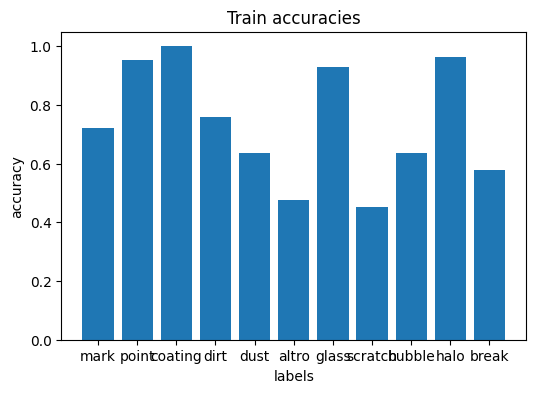

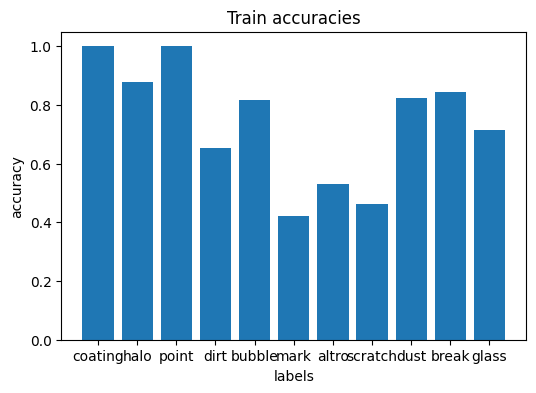

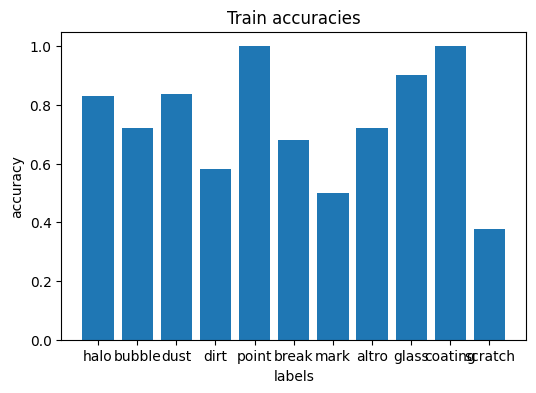

In [82]:
plot_accuracies_dict(train_accuracies_dict, 'Train recalls')

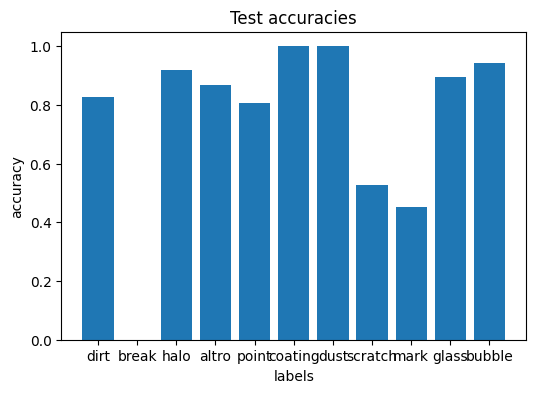

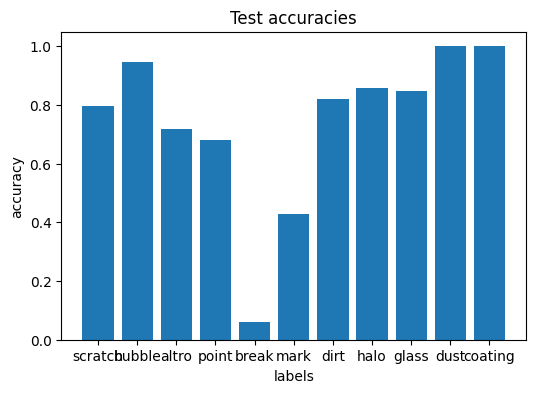

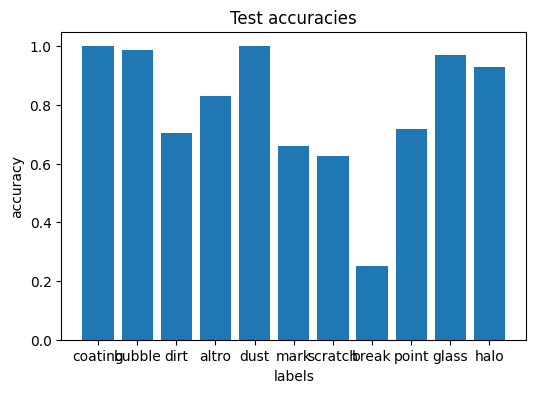

In [83]:
plot_accuracies_dict(test_accuracies_dict, 'Test recalls')

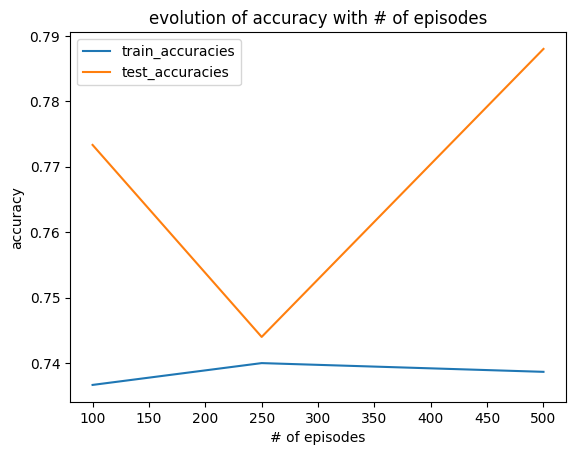

In [84]:
plot_accuracies(episodes_list, train_accuracies, test_accuracies)

# Using qplus dataset (detailed classes)

In [85]:
images, images_classes, images_dict = extract_images('../data/views_qplus/img/', '_did_')

In [86]:
classes = set(images_classes)
len(images), len(images_classes), len(classes)

(72, 72, 15)

In [87]:
classes

{'altro',
 'break',
 'bubble',
 'bubble_hole',
 'coating',
 'dirt',
 'dirt_halo',
 'dust',
 'glass_id',
 'halo',
 'mark',
 'point',
 'scratch_heavy',
 'scratch_light',
 'scratch_multi'}

In [88]:
images_dict = preprocess_images(images_dict, 23, 60)
target_classes = extend_target_classes(images_classes, 4)

In [89]:
train_test_pipeline(images_dict)

20
8
20
20
20
20
20
20
20
20
20
20
20
20
20
-----
15
6
15
15
15
15
15
15
15
15
15
15
15
15
15
-----
5
2
5
5
5
5
5
5
5
5
5
5
5
5
5


C:\Users\matte\AppData\Local\Temp\ipykernel_4876\1451704302.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes, desc="Epoch {:d} train".format(epoch+1)):


Epoch 1 train:   0%|          | 0/50 [00:00<?, ?it/s]

K: ['bubble_hole' 'mark' 'dust']
Epoch 1 -- Loss: 1.2415 Acc: 0.0133
K: ['mark' 'bubble_hole' 'point']
Epoch 2 -- Loss: 1.2415 Acc: 0.0333
K: ['scratch_multi' 'dirt' 'glass_id']
Epoch 3 -- Loss: 3.7157 Acc: 0.0400
K: ['point' 'scratch_multi' 'halo']
Epoch 4 -- Loss: 3.7366 Acc: 0.0533
K: ['bubble' 'break' 'glass_id']
Epoch 5 -- Loss: 3.7366 Acc: 0.0733
K: ['scratch_heavy' 'altro' 'dust']
Epoch 6 -- Loss: 3.7366 Acc: 0.0933
K: ['bubble' 'altro' 'scratch_light']
Epoch 7 -- Loss: 3.8115 Acc: 0.1067
K: ['bubble_hole' 'break' 'dirt']
Epoch 8 -- Loss: 7.9092 Acc: 0.1133
K: ['break' 'dirt' 'coating']
Epoch 9 -- Loss: 8.7852 Acc: 0.1200
K: ['scratch_heavy' 'scratch_light' 'glass_id']
Epoch 10 -- Loss: 10.9798 Acc: 0.1333
K: ['scratch_light' 'break' 'dust']
Epoch 11 -- Loss: 10.9816 Acc: 0.1533
K: ['coating' 'mark' 'glass_id']
Epoch 12 -- Loss: 11.6575 Acc: 0.1667
K: ['glass_id' 'point' 'halo']
Epoch 13 -- Loss: 11.6575 Acc: 0.1867
K: ['dust' 'altro' 'scratch_heavy']
Epoch 14 -- Loss: 14.2219 A

C:\Users\matte\AppData\Local\Temp\ipykernel_4876\2763146824.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes):


  0%|          | 0/50 [00:00<?, ?it/s]

K: ['bubble_hole' 'coating' 'dirt']
K: ['coating' 'scratch_multi' 'scratch_heavy']
K: ['glass_id' 'point' 'dirt']
K: ['altro' 'halo' 'dust']
K: ['dirt' 'mark' 'glass_id']
K: ['dirt' 'break' 'altro']
K: ['dirt' 'scratch_light' 'bubble_hole']
K: ['altro' 'scratch_light' 'bubble']
K: ['scratch_light' 'scratch_heavy' 'dirt']
K: ['bubble_hole' 'break' 'point']
K: ['glass_id' 'mark' 'bubble']
K: ['scratch_multi' 'mark' 'break']
K: ['bubble_hole' 'scratch_multi' 'bubble']
K: ['mark' 'glass_id' 'coating']
K: ['altro' 'coating' 'mark']
K: ['mark' 'halo' 'scratch_light']
K: ['mark' 'altro' 'scratch_light']
K: ['glass_id' 'coating' 'break']
K: ['scratch_heavy' 'coating' 'altro']
K: ['scratch_heavy' 'point' 'break']
K: ['scratch_multi' 'dust' 'halo']
K: ['dust' 'bubble_hole' 'bubble']
K: ['scratch_multi' 'altro' 'bubble_hole']
K: ['break' 'scratch_heavy' 'bubble_hole']
K: ['halo' 'altro' 'scratch_heavy']
K: ['scratch_multi' 'halo' 'point']
K: ['coating' 'halo' 'bubble_hole']
K: ['dirt' 'break' 'co

({'bubble_hole': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0],
  'mark': [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0],
  'dust': [1.0,
   1.0,
   1.0,
   0.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.0,
   0.0,
   0.0,
   1.0,
   1.0,
   1.0],
  'point': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  'scratch_multi': [1.0,
   0.0,
   1.0,
   1.0,
   1.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   1.0,
   1.0],
  'dirt': [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0],
  'glass_id': [0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0],
  'halo': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  'bubble': [1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0],
  'break': [1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0],
  'scratch_heavy': [1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
  'altro': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
  'scratch_light': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  'coating': [1.0, 1.0, 1.0, 1.0, 1

# Training and testing on different number of episodes

In [90]:
episodes_list, train_accuracies_dict, test_accuracies_dict, train_accuracies, test_accuracies = exec_multiple_episodes()

20
8
20
20
20
20
20
20
20
20
20
20
20
20
20
-----
15
6
15
15
15
15
15
15
15
15
15
15
15
15
15
-----
5
2
5
5
5
5
5
5
5
5
5
5
5
5
5


C:\Users\matte\AppData\Local\Temp\ipykernel_4876\1451704302.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes, desc="Epoch {:d} train".format(epoch+1)):


Epoch 1 train:   0%|          | 0/100 [00:00<?, ?it/s]

K: ['break' 'scratch_heavy' 'halo']
Epoch 1 -- Loss: 2.0808 Acc: 0.0033
K: ['coating' 'dirt' 'bubble']
Epoch 2 -- Loss: 2.7037 Acc: 0.0100
K: ['altro' 'scratch_light' 'scratch_heavy']
Epoch 3 -- Loss: 3.3203 Acc: 0.0133
K: ['bubble' 'coating' 'bubble_hole']
Epoch 4 -- Loss: 3.3250 Acc: 0.0200
K: ['dirt' 'glass_id' 'coating']
Epoch 5 -- Loss: 3.3250 Acc: 0.0300
K: ['dirt' 'break' 'bubble_hole']
Epoch 6 -- Loss: 3.3250 Acc: 0.0400
K: ['dirt_halo' 'scratch_multi' 'scratch_heavy']
Epoch 7 -- Loss: 4.3624 Acc: 0.0433
K: ['altro' 'halo' 'dirt_halo']
Epoch 8 -- Loss: 4.3940 Acc: 0.0500
K: ['dirt' 'scratch_heavy' 'dust']
Epoch 9 -- Loss: 5.3746 Acc: 0.0567
K: ['dirt_halo' 'scratch_light' 'halo']
Epoch 10 -- Loss: 5.3746 Acc: 0.0667
K: ['altro' 'dirt' 'bubble']
Epoch 11 -- Loss: 5.3764 Acc: 0.0767
K: ['coating' 'scratch_heavy' 'scratch_multi']
Epoch 12 -- Loss: 5.6401 Acc: 0.0833
K: ['point' 'halo' 'dust']
Epoch 13 -- Loss: 5.8365 Acc: 0.0900
K: ['bubble_hole' 'scratch_light' 'bubble']
Epoch 14

C:\Users\matte\AppData\Local\Temp\ipykernel_4876\2763146824.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes):


  0%|          | 0/100 [00:00<?, ?it/s]

K: ['point' 'scratch_heavy' 'dirt']
K: ['break' 'scratch_multi' 'mark']
K: ['dirt_halo' 'break' 'dirt']
K: ['dust' 'bubble' 'bubble_hole']
K: ['bubble_hole' 'glass_id' 'scratch_multi']
K: ['bubble_hole' 'dirt' 'scratch_heavy']
K: ['dirt_halo' 'scratch_light' 'dirt']
K: ['point' 'glass_id' 'halo']
K: ['point' 'glass_id' 'scratch_multi']
K: ['scratch_heavy' 'mark' 'scratch_light']
K: ['halo' 'glass_id' 'dust']
K: ['break' 'dust' 'scratch_multi']
K: ['scratch_multi' 'dirt' 'break']
K: ['dirt_halo' 'point' 'scratch_heavy']
K: ['halo' 'dust' 'dirt_halo']
K: ['mark' 'bubble_hole' 'altro']
K: ['bubble' 'coating' 'mark']
K: ['dirt' 'bubble' 'dust']
K: ['mark' 'altro' 'dirt_halo']
K: ['bubble' 'bubble_hole' 'dirt_halo']
K: ['mark' 'dirt_halo' 'dust']
K: ['scratch_heavy' 'point' 'dust']
K: ['point' 'glass_id' 'altro']
K: ['bubble' 'scratch_multi' 'dust']
K: ['halo' 'scratch_light' 'bubble_hole']
K: ['altro' 'bubble' 'point']
K: ['dirt_halo' 'halo' 'scratch_light']
K: ['scratch_light' 'halo' 'poi

Epoch 1 train:   0%|          | 0/250 [00:00<?, ?it/s]

K: ['bubble' 'point' 'halo']
Epoch 1 -- Loss: 0.4809 Acc: 0.0013
K: ['point' 'dirt' 'dirt_halo']
Epoch 2 -- Loss: 0.4833 Acc: 0.0040
K: ['scratch_light' 'coating' 'scratch_heavy']
Epoch 3 -- Loss: 0.4833 Acc: 0.0080
K: ['dirt_halo' 'dirt' 'dust']
Epoch 4 -- Loss: 0.6713 Acc: 0.0107
K: ['scratch_light' 'glass_id' 'dirt_halo']
Epoch 5 -- Loss: 0.6713 Acc: 0.0147
K: ['dirt_halo' 'scratch_heavy' 'altro']
Epoch 6 -- Loss: 0.7415 Acc: 0.0173
K: ['bubble' 'dirt' 'dirt_halo']
Epoch 7 -- Loss: 0.7431 Acc: 0.0200
K: ['coating' 'glass_id' 'dust']
Epoch 8 -- Loss: 0.7431 Acc: 0.0240
K: ['scratch_light' 'dust' 'point']
Epoch 9 -- Loss: 0.7431 Acc: 0.0280
K: ['altro' 'dirt' 'break']
Epoch 10 -- Loss: 1.1571 Acc: 0.0293
K: ['break' 'mark' 'dirt']
Epoch 11 -- Loss: 1.3542 Acc: 0.0320
K: ['halo' 'mark' 'dirt']
Epoch 12 -- Loss: 1.7711 Acc: 0.0333
K: ['dirt' 'bubble' 'altro']
Epoch 13 -- Loss: 1.8444 Acc: 0.0360
K: ['coating' 'dirt_halo' 'scratch_multi']
Epoch 14 -- Loss: 1.8793 Acc: 0.0387
K: ['point' 

  0%|          | 0/250 [00:00<?, ?it/s]

K: ['point' 'dust' 'altro']
K: ['bubble_hole' 'dust' 'coating']
K: ['scratch_light' 'bubble_hole' 'mark']
K: ['dirt' 'point' 'scratch_heavy']
K: ['dust' 'point' 'scratch_heavy']
K: ['bubble' 'dust' 'bubble_hole']
K: ['bubble' 'bubble_hole' 'break']
K: ['point' 'dirt_halo' 'halo']
K: ['point' 'bubble_hole' 'break']
K: ['dirt_halo' 'bubble' 'scratch_multi']
K: ['point' 'dirt' 'scratch_light']
K: ['coating' 'glass_id' 'break']
K: ['dust' 'bubble_hole' 'break']
K: ['scratch_multi' 'mark' 'bubble']
K: ['dust' 'scratch_multi' 'altro']
K: ['mark' 'dirt_halo' 'coating']
K: ['dirt_halo' 'altro' 'mark']
K: ['scratch_heavy' 'coating' 'bubble_hole']
K: ['mark' 'scratch_multi' 'dirt_halo']
K: ['dust' 'mark' 'bubble']
K: ['dirt_halo' 'altro' 'dust']
K: ['scratch_light' 'dirt_halo' 'scratch_multi']
K: ['dust' 'glass_id' 'scratch_multi']
K: ['dust' 'bubble' 'bubble_hole']
K: ['scratch_heavy' 'dirt' 'break']
K: ['dust' 'dirt' 'mark']
K: ['glass_id' 'bubble' 'point']
K: ['altro' 'scratch_light' 'dirt']


Epoch 1 train:   0%|          | 0/500 [00:00<?, ?it/s]

K: ['break' 'scratch_heavy' 'point']
Epoch 1 -- Loss: 0.0000 Acc: 0.0020
K: ['scratch_light' 'dust' 'glass_id']
Epoch 2 -- Loss: 0.0000 Acc: 0.0040
K: ['glass_id' 'scratch_light' 'mark']
Epoch 3 -- Loss: 0.0309 Acc: 0.0047
K: ['mark' 'scratch_light' 'scratch_multi']
Epoch 4 -- Loss: 0.0309 Acc: 0.0067
K: ['bubble' 'dust' 'mark']
Epoch 5 -- Loss: 0.0309 Acc: 0.0087
K: ['mark' 'point' 'dust']
Epoch 6 -- Loss: 0.0309 Acc: 0.0107
K: ['mark' 'scratch_light' 'bubble']
Epoch 7 -- Loss: 0.0309 Acc: 0.0127
K: ['dirt_halo' 'break' 'scratch_heavy']
Epoch 8 -- Loss: 0.1945 Acc: 0.0140
K: ['scratch_multi' 'mark' 'bubble']
Epoch 9 -- Loss: 0.2482 Acc: 0.0153
K: ['scratch_light' 'dirt' 'glass_id']
Epoch 10 -- Loss: 0.3499 Acc: 0.0167
K: ['mark' 'glass_id' 'scratch_light']
Epoch 11 -- Loss: 0.3499 Acc: 0.0187
K: ['dust' 'bubble' 'break']
Epoch 12 -- Loss: 0.3499 Acc: 0.0207
K: ['altro' 'dust' 'halo']
Epoch 13 -- Loss: 0.4172 Acc: 0.0220
K: ['dirt_halo' 'altro' 'dirt']
Epoch 14 -- Loss: 0.5248 Acc: 0.0

  0%|          | 0/500 [00:00<?, ?it/s]

K: ['dirt_halo' 'scratch_multi' 'glass_id']
K: ['halo' 'mark' 'glass_id']
K: ['dirt_halo' 'coating' 'dust']
K: ['mark' 'dust' 'break']
K: ['altro' 'dirt' 'scratch_heavy']
K: ['dirt' 'scratch_light' 'point']
K: ['altro' 'scratch_heavy' 'scratch_light']
K: ['glass_id' 'scratch_light' 'dirt_halo']
K: ['mark' 'point' 'break']
K: ['coating' 'bubble_hole' 'bubble']
K: ['dirt_halo' 'bubble' 'coating']
K: ['coating' 'break' 'scratch_light']
K: ['halo' 'scratch_heavy' 'break']
K: ['scratch_multi' 'point' 'scratch_light']
K: ['scratch_heavy' 'break' 'halo']
K: ['bubble' 'scratch_multi' 'altro']
K: ['dust' 'break' 'mark']
K: ['altro' 'dirt' 'bubble_hole']
K: ['bubble_hole' 'dirt' 'coating']
K: ['mark' 'dirt_halo' 'altro']
K: ['bubble' 'dirt' 'glass_id']
K: ['dust' 'coating' 'mark']
K: ['glass_id' 'scratch_heavy' 'mark']
K: ['dust' 'scratch_heavy' 'scratch_light']
K: ['break' 'dirt' 'mark']
K: ['scratch_heavy' 'break' 'bubble']
K: ['scratch_multi' 'glass_id' 'scratch_light']
K: ['bubble_hole' 'dir

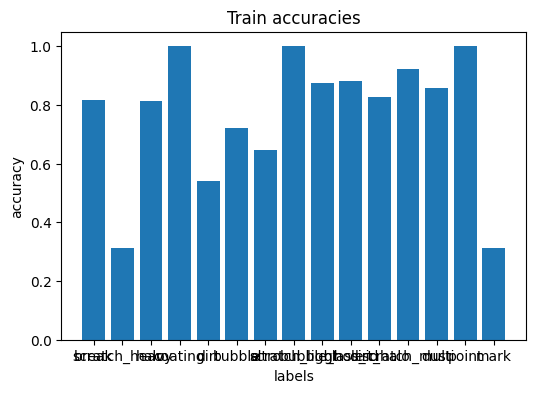

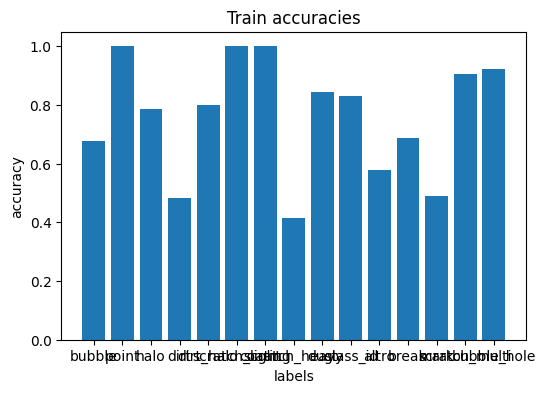

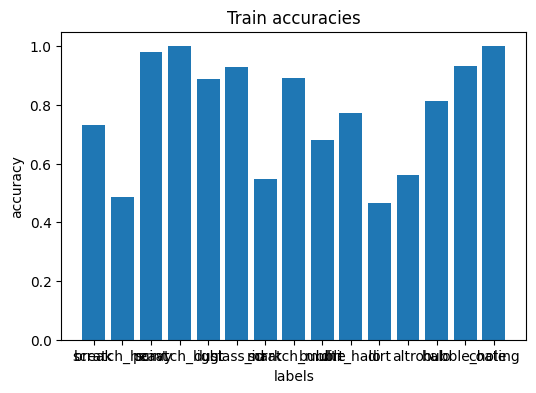

In [91]:
plot_accuracies_dict(train_accuracies_dict, 'Train recalls')

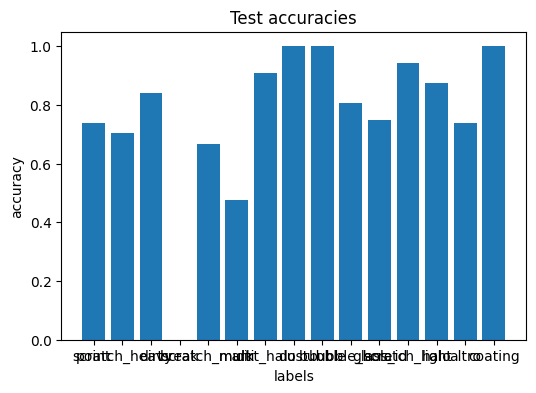

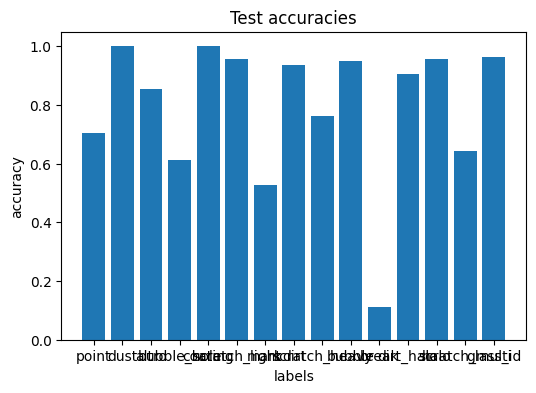

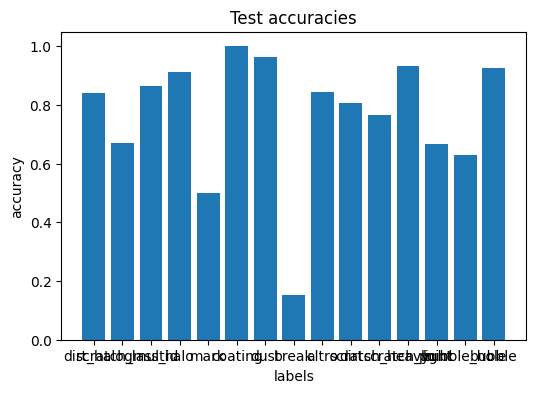

In [92]:
plot_accuracies_dict(test_accuracies_dict, 'Test recalls')

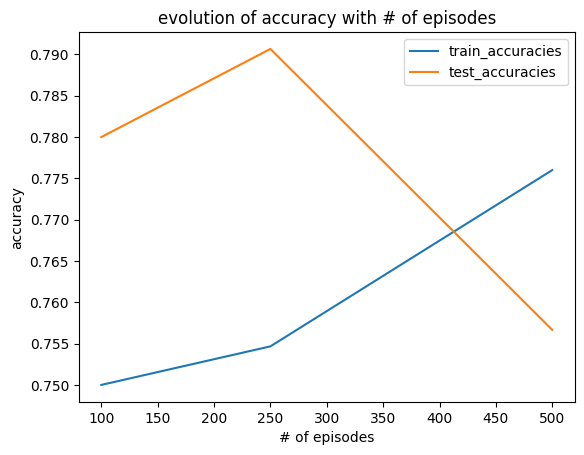

In [93]:
plot_accuracies(episodes_list, train_accuracies, test_accuracies)

# Using qplus dataset to predict opt_bckg

In [94]:
train_images, train_images_classes, train_images_dict = extract_images('../data/views_qplus/img/', '_did_')

In [95]:
train_classes = set(train_images_classes)
len(train_images), len(train_images_classes), len(train_classes)

(72, 72, 15)

In [96]:
train_classes

{'altro',
 'break',
 'bubble',
 'bubble_hole',
 'coating',
 'dirt',
 'dirt_halo',
 'dust',
 'glass_id',
 'halo',
 'mark',
 'point',
 'scratch_heavy',
 'scratch_light',
 'scratch_multi'}

In [97]:
train_images_dict = preprocess_images(train_images_dict, 23, 60)
train_target_classes = extend_target_classes(train_images_classes, 4)

In [98]:
test_images, test_images_classes, test_images_dict = extract_images('../data/views_opt_bckg/img/')

In [99]:
test_classes = set(test_images_classes)
len(test_images), len(test_images_classes), len(test_classes)

(31, 31, 7)

In [100]:
test_classes

{'background', 'break', 'bubble', 'dirt', 'mark', 'point', 'scratch'}

In [101]:
test_images_dict = preprocess_images(test_images_dict, 26, 60)
test_target_classes = extend_target_classes(test_images_classes, 4)

In [103]:
model = load_protonet_conv(
    x_dim=(3,60,60),
    hid_dim=64,
    z_dim=64,
)

optimizer = optim.Adam(model.parameters(), lr = 0.001)

train_accuracy_dict, train_accuracy  = train(model, optimizer, train_images_dict, train_target_classes, 3, 2, 1, 50, 50)

test_accuracy_dict, test_accuracy  = test(model, test_images_dict, test_target_classes, 3, 1, 1, 50)

print('----------------------------------------------')
print('Train results')
print_dictionary(train_accuracy_dict)
print('----------------------------------------------')
print('Test results')
print_dictionary(test_accuracy_dict)

C:\Users\matte\AppData\Local\Temp\ipykernel_4876\1451704302.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes, desc="Epoch {:d} train".format(epoch+1)):


Epoch 1 train:   0%|          | 0/50 [00:00<?, ?it/s]

K: ['dirt_halo' 'altro' 'dust']
Epoch 1 -- Loss: 0.5818 Acc: 0.0133
K: ['scratch_light' 'coating' 'break']
Epoch 2 -- Loss: 0.6673 Acc: 0.0267
K: ['dust' 'glass_id' 'dirt_halo']
Epoch 3 -- Loss: 0.6673 Acc: 0.0467
K: ['scratch_heavy' 'point' 'break']
Epoch 4 -- Loss: 1.6829 Acc: 0.0600
K: ['mark' 'altro' 'dirt_halo']
Epoch 5 -- Loss: 2.0115 Acc: 0.0733
K: ['dirt_halo' 'point' 'bubble_hole']
Epoch 6 -- Loss: 3.7467 Acc: 0.0867
K: ['scratch_heavy' 'dirt_halo' 'bubble_hole']
Epoch 7 -- Loss: 3.7467 Acc: 0.1067
K: ['coating' 'halo' 'dirt']
Epoch 8 -- Loss: 3.7467 Acc: 0.1267
K: ['scratch_multi' 'bubble_hole' 'scratch_heavy']
Epoch 9 -- Loss: 3.7467 Acc: 0.1467
K: ['coating' 'glass_id' 'halo']
Epoch 10 -- Loss: 3.7467 Acc: 0.1667
K: ['scratch_multi' 'break' 'point']
Epoch 11 -- Loss: 4.2132 Acc: 0.1800
K: ['halo' 'bubble_hole' 'altro']
Epoch 12 -- Loss: 5.5510 Acc: 0.1867
K: ['scratch_heavy' 'altro' 'bubble']
Epoch 13 -- Loss: 7.1142 Acc: 0.1933
K: ['glass_id' 'scratch_multi' 'dirt_halo']
E

C:\Users\matte\AppData\Local\Temp\ipykernel_4876\2763146824.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes):


  0%|          | 0/50 [00:00<?, ?it/s]

K: ['bubble' 'scratch' 'mark']
K: ['break' 'bubble' 'scratch']
K: ['dirt' 'scratch' 'point']
K: ['background' 'point' 'mark']
K: ['break' 'background' 'dirt']
K: ['bubble' 'dirt' 'point']
K: ['bubble' 'background' 'break']
K: ['bubble' 'background' 'scratch']
K: ['point' 'dirt' 'scratch']
K: ['dirt' 'break' 'background']
K: ['break' 'bubble' 'scratch']
K: ['scratch' 'mark' 'bubble']
K: ['scratch' 'mark' 'break']
K: ['mark' 'scratch' 'background']
K: ['point' 'break' 'scratch']
K: ['mark' 'break' 'scratch']
K: ['scratch' 'break' 'bubble']
K: ['scratch' 'point' 'break']
K: ['break' 'bubble' 'scratch']
K: ['point' 'scratch' 'break']
K: ['dirt' 'bubble' 'mark']
K: ['mark' 'background' 'bubble']
K: ['bubble' 'dirt' 'break']
K: ['scratch' 'dirt' 'background']
K: ['bubble' 'dirt' 'scratch']
K: ['background' 'point' 'dirt']
K: ['background' 'dirt' 'bubble']
K: ['bubble' 'point' 'scratch']
K: ['point' 'bubble' 'background']
K: ['dirt' 'mark' 'point']
K: ['dirt' 'mark' 'background']
K: ['mark' '

# Training and testing on different number of episodes

In [104]:
increased_episodes = [50, 100, 250, 500]
train_accuracies_dict, test_accuracies_dict = [], []
train_accuracies, test_accuracies = [], []

for episodes in increased_episodes:
    train_accuracy_dict, train_accuracy = train(model, optimizer, train_images_dict, train_target_classes, 3, 2, 1, 50, episodes)
    test_accuracy_dict, test_accuracy = test(model, test_images_dict, test_target_classes, 3, 1, 1, episodes)
    train_accuracies_dict.append(train_accuracy_dict)
    test_accuracies_dict.append(test_accuracy_dict)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

C:\Users\matte\AppData\Local\Temp\ipykernel_4876\1451704302.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes, desc="Epoch {:d} train".format(epoch+1)):


Epoch 1 train:   0%|          | 0/100 [00:00<?, ?it/s]

K: ['scratch_light' 'point' 'dirt_halo']
Epoch 1 -- Loss: 0.0001 Acc: 0.0100
K: ['bubble_hole' 'dust' 'dirt_halo']
Epoch 2 -- Loss: 0.1235 Acc: 0.0167
K: ['break' 'bubble_hole' 'scratch_multi']
Epoch 3 -- Loss: 0.1235 Acc: 0.0267
K: ['coating' 'bubble_hole' 'halo']
Epoch 4 -- Loss: 0.1895 Acc: 0.0333
K: ['point' 'bubble' 'altro']
Epoch 5 -- Loss: 2.5396 Acc: 0.0367
K: ['glass_id' 'break' 'scratch_heavy']
Epoch 6 -- Loss: 2.5396 Acc: 0.0467
K: ['dirt' 'mark' 'halo']
Epoch 7 -- Loss: 2.9663 Acc: 0.0500
K: ['coating' 'halo' 'point']
Epoch 8 -- Loss: 3.1919 Acc: 0.0567
K: ['coating' 'scratch_light' 'dirt']
Epoch 9 -- Loss: 3.1919 Acc: 0.0667
K: ['mark' 'dust' 'point']
Epoch 10 -- Loss: 3.2396 Acc: 0.0733
K: ['scratch_light' 'altro' 'bubble_hole']
Epoch 11 -- Loss: 3.6384 Acc: 0.0800
K: ['dirt' 'altro' 'bubble_hole']
Epoch 12 -- Loss: 5.0898 Acc: 0.0833
K: ['bubble' 'dirt_halo' 'altro']
Epoch 13 -- Loss: 5.0899 Acc: 0.0933
K: ['bubble_hole' 'halo' 'mark']
Epoch 14 -- Loss: 5.6492 Acc: 0.096

C:\Users\matte\AppData\Local\Temp\ipykernel_4876\2763146824.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes):


  0%|          | 0/100 [00:00<?, ?it/s]

K: ['point' 'scratch' 'bubble']
K: ['break' 'point' 'mark']
K: ['bubble' 'break' 'mark']
K: ['break' 'scratch' 'bubble']
K: ['mark' 'dirt' 'scratch']
K: ['bubble' 'dirt' 'mark']
K: ['point' 'scratch' 'bubble']
K: ['bubble' 'mark' 'point']
K: ['mark' 'break' 'point']
K: ['dirt' 'point' 'background']
K: ['dirt' 'background' 'break']
K: ['break' 'background' 'mark']
K: ['scratch' 'bubble' 'point']
K: ['background' 'dirt' 'break']
K: ['dirt' 'break' 'background']
K: ['point' 'mark' 'background']
K: ['background' 'point' 'dirt']
K: ['break' 'mark' 'scratch']
K: ['scratch' 'bubble' 'point']
K: ['dirt' 'background' 'scratch']
K: ['mark' 'dirt' 'scratch']
K: ['point' 'background' 'bubble']
K: ['break' 'background' 'bubble']
K: ['dirt' 'scratch' 'point']
K: ['bubble' 'mark' 'dirt']
K: ['mark' 'dirt' 'background']
K: ['break' 'point' 'mark']
K: ['point' 'break' 'scratch']
K: ['scratch' 'point' 'mark']
K: ['break' 'bubble' 'dirt']
K: ['point' 'background' 'break']
K: ['bubble' 'point' 'background

Epoch 1 train:   0%|          | 0/250 [00:00<?, ?it/s]

K: ['coating' 'scratch_heavy' 'bubble']
Epoch 1 -- Loss: 0.0985 Acc: 0.0027
K: ['dirt' 'break' 'bubble_hole']
Epoch 2 -- Loss: 0.7551 Acc: 0.0040
K: ['mark' 'glass_id' 'scratch_heavy']
Epoch 3 -- Loss: 0.8175 Acc: 0.0067
K: ['altro' 'coating' 'scratch_multi']
Epoch 4 -- Loss: 1.2854 Acc: 0.0093
K: ['mark' 'dirt_halo' 'coating']
Epoch 5 -- Loss: 1.5790 Acc: 0.0120
K: ['dirt_halo' 'bubble_hole' 'halo']
Epoch 6 -- Loss: 1.9980 Acc: 0.0133
K: ['scratch_light' 'dirt' 'dust']
Epoch 7 -- Loss: 2.0011 Acc: 0.0160
K: ['dirt' 'bubble' 'coating']
Epoch 8 -- Loss: 2.0128 Acc: 0.0187
K: ['dirt' 'scratch_heavy' 'dirt_halo']
Epoch 9 -- Loss: 2.1505 Acc: 0.0213
K: ['scratch_multi' 'scratch_heavy' 'coating']
Epoch 10 -- Loss: 2.1505 Acc: 0.0253
K: ['dust' 'scratch_multi' 'scratch_light']
Epoch 11 -- Loss: 2.6353 Acc: 0.0267
K: ['scratch_heavy' 'altro' 'break']
Epoch 12 -- Loss: 2.9893 Acc: 0.0280
K: ['glass_id' 'bubble' 'dust']
Epoch 13 -- Loss: 2.9893 Acc: 0.0320
K: ['altro' 'mark' 'scratch_multi']
Ep

  0%|          | 0/250 [00:00<?, ?it/s]

K: ['scratch' 'background' 'bubble']
K: ['mark' 'bubble' 'scratch']
K: ['background' 'scratch' 'point']
K: ['break' 'mark' 'bubble']
K: ['point' 'break' 'mark']
K: ['break' 'dirt' 'mark']
K: ['dirt' 'bubble' 'background']
K: ['bubble' 'dirt' 'background']
K: ['point' 'mark' 'bubble']
K: ['mark' 'background' 'dirt']
K: ['dirt' 'mark' 'background']
K: ['point' 'mark' 'dirt']
K: ['scratch' 'background' 'point']
K: ['break' 'background' 'mark']
K: ['bubble' 'point' 'background']
K: ['background' 'break' 'point']
K: ['mark' 'point' 'bubble']
K: ['background' 'mark' 'scratch']
K: ['bubble' 'dirt' 'scratch']
K: ['background' 'scratch' 'mark']
K: ['scratch' 'dirt' 'background']
K: ['scratch' 'break' 'mark']
K: ['background' 'scratch' 'mark']
K: ['bubble' 'scratch' 'dirt']
K: ['dirt' 'bubble' 'point']
K: ['background' 'bubble' 'point']
K: ['mark' 'point' 'scratch']
K: ['point' 'scratch' 'break']
K: ['scratch' 'point' 'mark']
K: ['mark' 'break' 'background']
K: ['scratch' 'mark' 'point']
K: ['bu

Epoch 1 train:   0%|          | 0/500 [00:00<?, ?it/s]

K: ['coating' 'altro' 'dirt_halo']
Epoch 1 -- Loss: 0.0340 Acc: 0.0013
K: ['glass_id' 'bubble' 'scratch_heavy']
Epoch 2 -- Loss: 0.0340 Acc: 0.0033
K: ['point' 'altro' 'bubble_hole']
Epoch 3 -- Loss: 0.0753 Acc: 0.0040
K: ['point' 'scratch_heavy' 'break']
Epoch 4 -- Loss: 0.1819 Acc: 0.0047
K: ['scratch_multi' 'scratch_light' 'halo']
Epoch 5 -- Loss: 0.2998 Acc: 0.0060
K: ['mark' 'coating' 'bubble_hole']
Epoch 6 -- Loss: 0.3096 Acc: 0.0073
K: ['mark' 'coating' 'point']
Epoch 7 -- Loss: 0.3096 Acc: 0.0093
K: ['coating' 'mark' 'dirt_halo']
Epoch 8 -- Loss: 0.3189 Acc: 0.0107
K: ['scratch_heavy' 'glass_id' 'point']
Epoch 9 -- Loss: 0.4164 Acc: 0.0120
K: ['scratch_light' 'altro' 'glass_id']
Epoch 10 -- Loss: 0.5587 Acc: 0.0133
K: ['altro' 'dust' 'coating']
Epoch 11 -- Loss: 0.5587 Acc: 0.0153
K: ['altro' 'dirt_halo' 'mark']
Epoch 12 -- Loss: 0.5779 Acc: 0.0160
K: ['break' 'dirt' 'bubble_hole']
Epoch 13 -- Loss: 0.7990 Acc: 0.0167
K: ['altro' 'scratch_heavy' 'bubble_hole']
Epoch 14 -- Loss:

  0%|          | 0/500 [00:00<?, ?it/s]

K: ['bubble' 'scratch' 'break']
K: ['break' 'bubble' 'scratch']
K: ['scratch' 'background' 'bubble']
K: ['dirt' 'point' 'background']
K: ['break' 'mark' 'background']
K: ['scratch' 'point' 'break']
K: ['point' 'background' 'mark']
K: ['mark' 'background' 'scratch']
K: ['break' 'mark' 'background']
K: ['dirt' 'scratch' 'background']
K: ['mark' 'break' 'dirt']
K: ['bubble' 'background' 'dirt']
K: ['point' 'break' 'scratch']
K: ['mark' 'scratch' 'background']
K: ['bubble' 'background' 'break']
K: ['dirt' 'point' 'mark']
K: ['mark' 'scratch' 'bubble']
K: ['mark' 'break' 'bubble']
K: ['mark' 'bubble' 'break']
K: ['bubble' 'scratch' 'mark']
K: ['bubble' 'scratch' 'background']
K: ['bubble' 'scratch' 'background']
K: ['bubble' 'background' 'scratch']
K: ['break' 'dirt' 'scratch']
K: ['break' 'mark' 'point']
K: ['mark' 'background' 'point']
K: ['background' 'break' 'point']
K: ['background' 'bubble' 'point']
K: ['point' 'break' 'dirt']
K: ['background' 'break' 'scratch']
K: ['bubble' 'backgrou

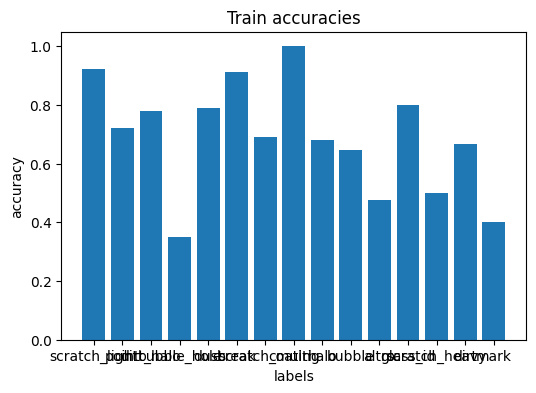

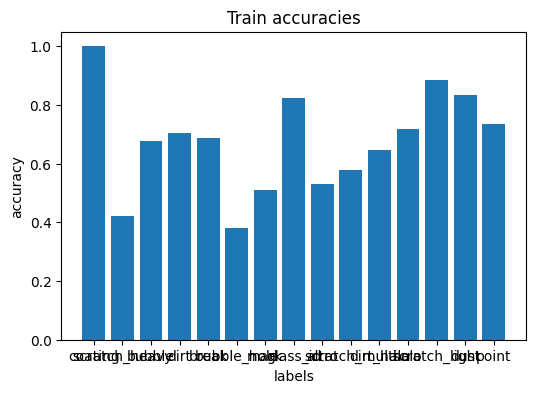

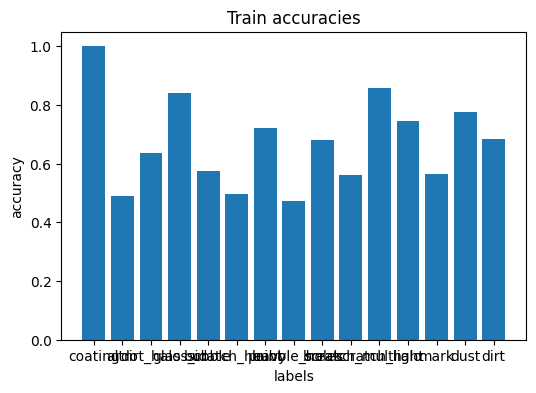

In [105]:
plot_accuracies_dict(train_accuracies_dict, 'Train recalls')

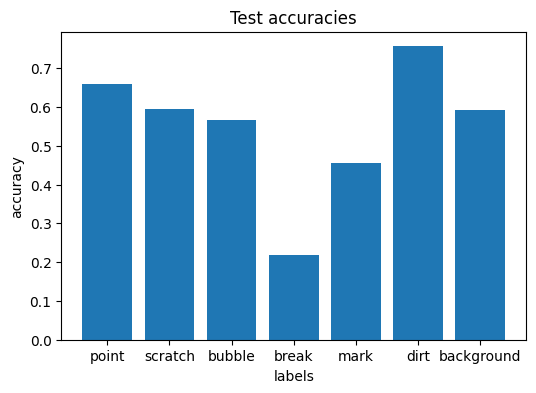

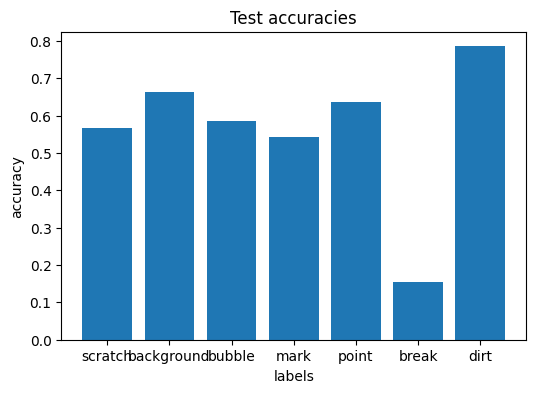

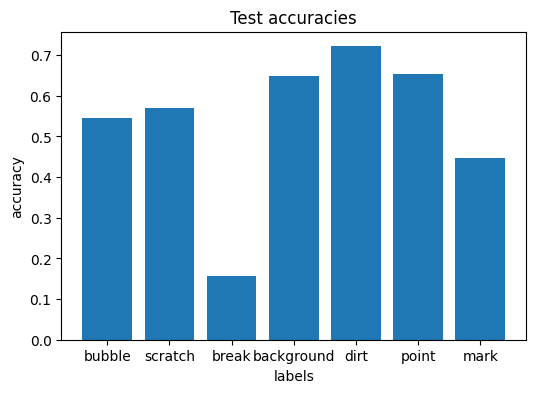

In [106]:
plot_accuracies_dict(test_accuracies_dict, 'Test recalls')

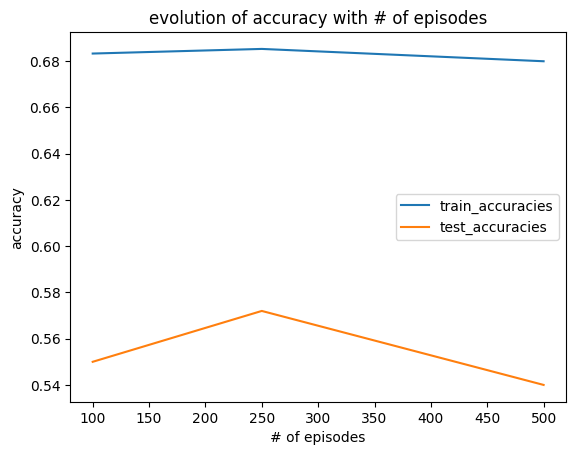

In [107]:
plot_accuracies(episodes_list, train_accuracies, test_accuracies)

In [ ]:
# train_accuracy_dict = train(model, optimizer, train_images_dict, train_target_classes, 3, 2, 1, 50, 100)

# test_accuracy_dict = test(model, test_images_dict, test_target_classes, 3, 1, 1, 100)

# print('----------------------------------------------')
# print('Train results')
# print_dictionary(train_accuracy_dict)
# print('----------------------------------------------')
# print('Test results')
# print_dictionary(test_accuracy_dict)

In [ ]:
# train_accuracy_dict = train(model, optimizer, train_images_dict, train_target_classes, 3, 2, 1, 50, 250)

# test_accuracy_dict = test(model, test_images_dict, test_target_classes, 3, 1, 1, 250)

# print('----------------------------------------------')
# print('Train results')
# print_dictionary(train_accuracy_dict)
# print('----------------------------------------------')
# print('Test results')
# print_dictionary(test_accuracy_dict)

In [ ]:
# train_accuracy_dict = train(model, optimizer, train_images_dict, train_target_classes, 3, 2, 1, 50, 500)

# test_accuracy_dict = test(model, test_images_dict, test_target_classes, 3, 1, 1, 500)

# print('----------------------------------------------')
# print('Train results')
# print_dictionary(train_accuracy_dict)
# print('----------------------------------------------')
# print('Test results')
# print_dictionary(test_accuracy_dict)

In [ ]:
print('Finito!')